In [109]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [155]:
nx = 601                # number of grid points
dx = 1000.0             # grid spacing = 1km
dt = 30.0               # time interval = 30 second
n_total = 3000          # final time step
out_step = 30           # number of time steps between output
                        # output is written every 30s x 50 = 25 mins
D = 200.                # propagation speed > 0 (upwind) 
rho = D * dt / (dx ** 2)
c = 15.0                # propagation speed > 0 (upwind) 
sigma = c * dt / dx
path = os.getcwd() + '\\figs\\'
rho, sigma

(0.006, 0.45)

In [110]:
def plot_n_save(n, data, path, save, out_step):
    if n%out_step == 0:
        title = str(n).zfill(5)
        filename = path + title + f'.png'
        fig = plt.figure(figsize = (6, 4), dpi = 80)
        ax = fig.add_subplot()
        ax.set_xlim(0,600)
        ax.set_ylim(-0.5,1.5)
        ax.set_ylabel('u (mag)', fontsize = 15)
        ax.set_xlabel('x (km)', fontsize = 15)
        ax.set_title(title, fontsize = 15)
        ax.set_facecolor('#E6E6E6')
        sns.lineplot(data = data[n])
        sns.lineplot(data = data[0])
        if save:
            plt.savefig(filename, dpi = 300)
        else:
            plt.show()
        plt.close()

In [154]:
def IC(nx):
    IC = np.zeros(nx)                 #IC initialize
    # x = np.linspace(0, nx, num = int(nx))
    # IC = np.exp(-8e-4*(x-nx/2)**2)
    IC[nx//2-10:nx//2+10] = 1.
    # np.cos(np.linspace(-1., 1., 20))   #IC
    return IC

In [128]:
def BC(BC_method, u_next, u_now):
    if BC_method == 'fixed':          #fixed in time boundary condition
        u_next[0] = u_now[0]          #BC@x=0
        u_next[-1] = u_now[-1]        #BC@x=L
        
    if BC_method == 'periodic':       #periodic boundary condition
        u_next[0] = u_next[-2]
        u_next[-1] = u_next[1]

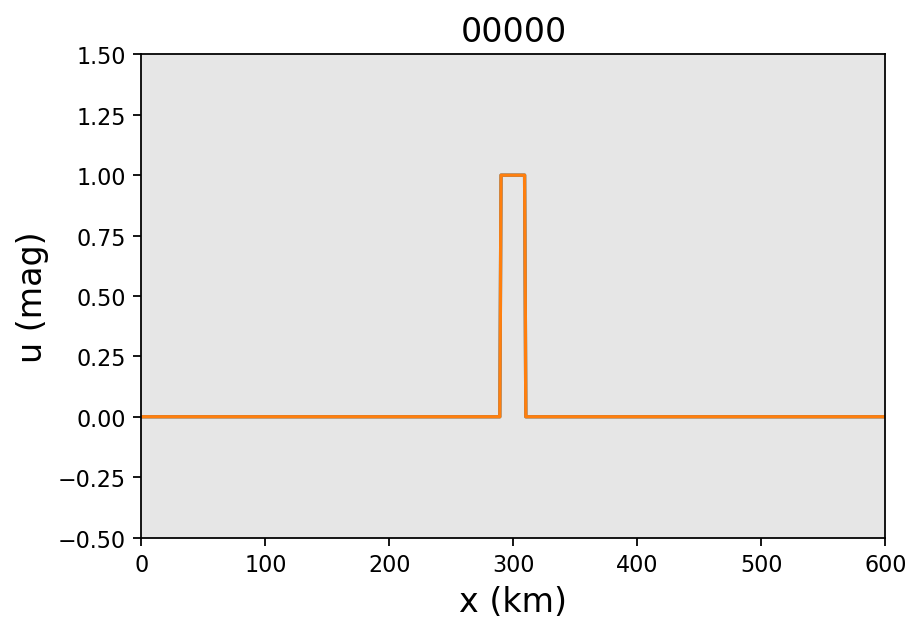

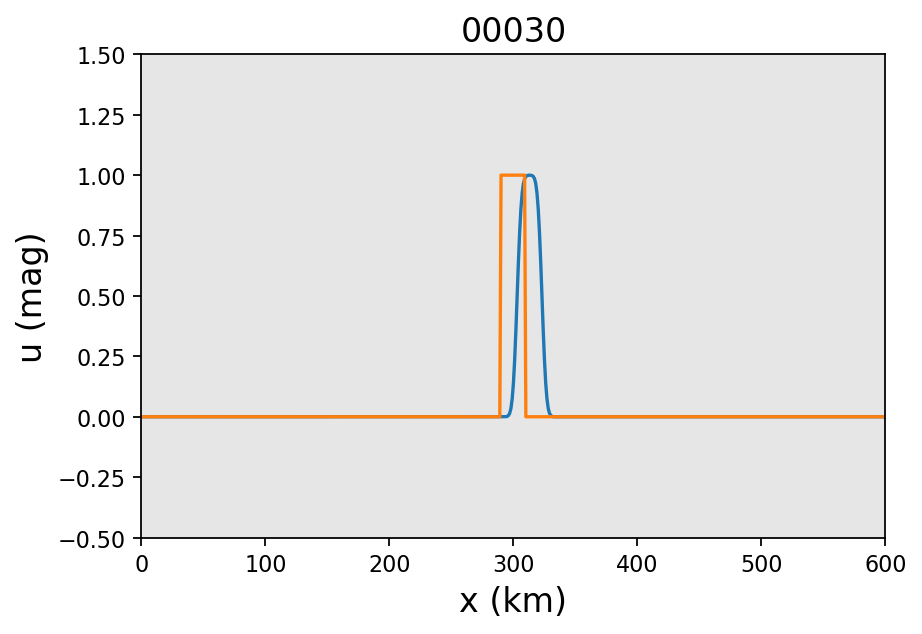

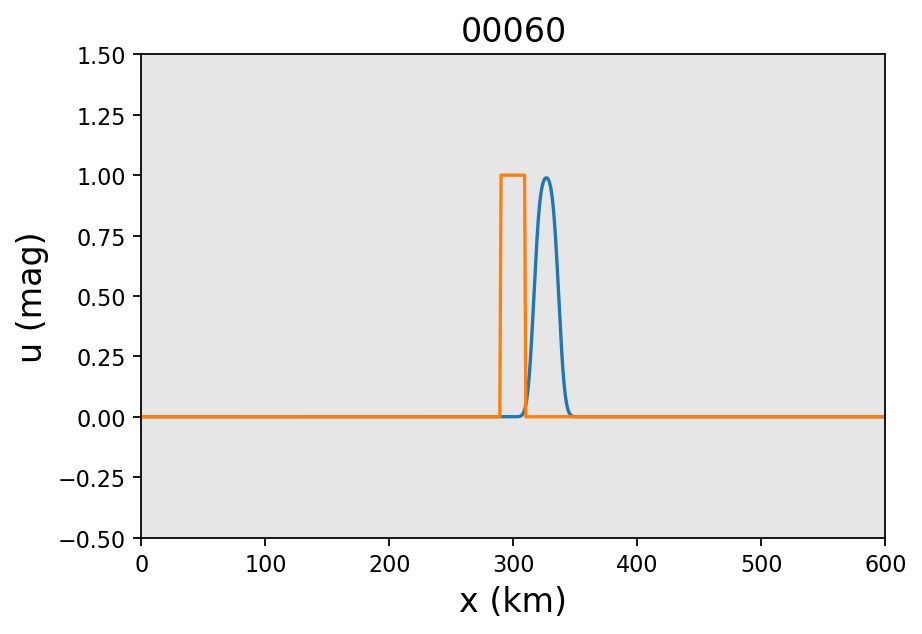

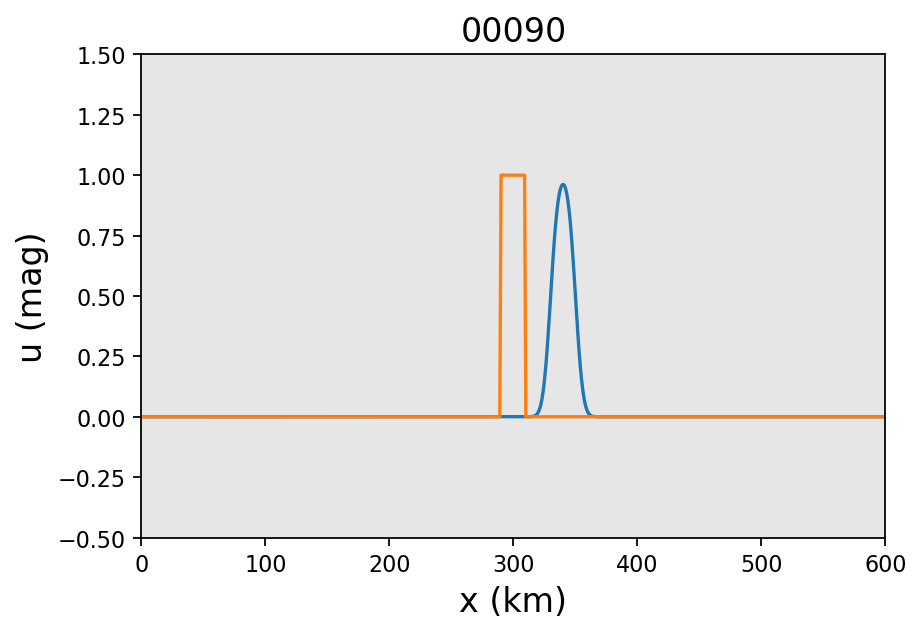

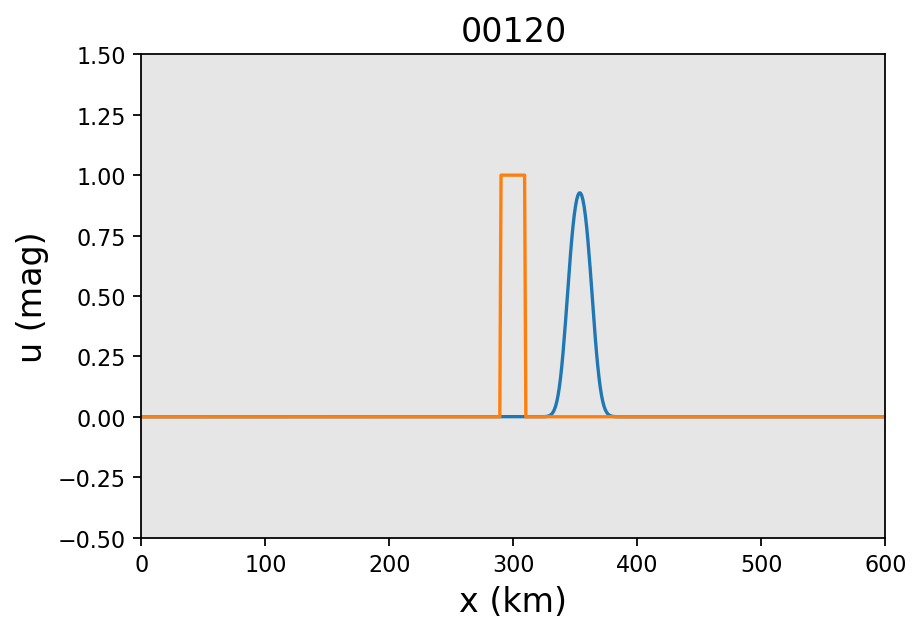

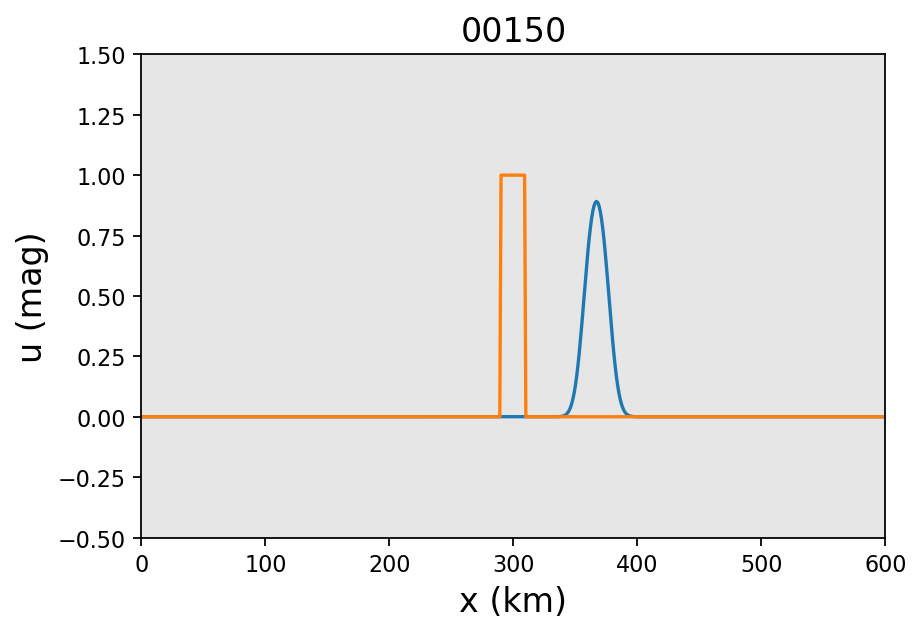

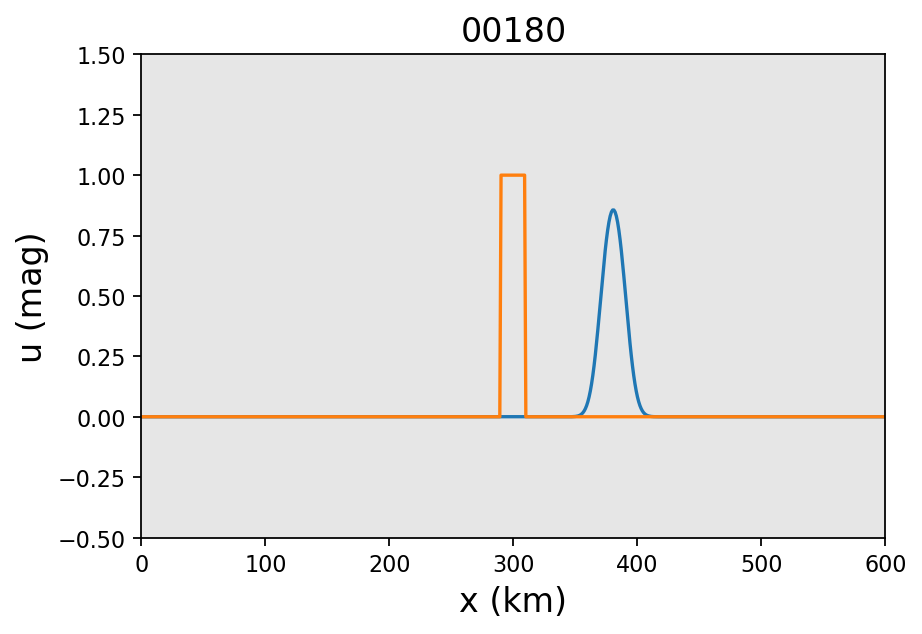

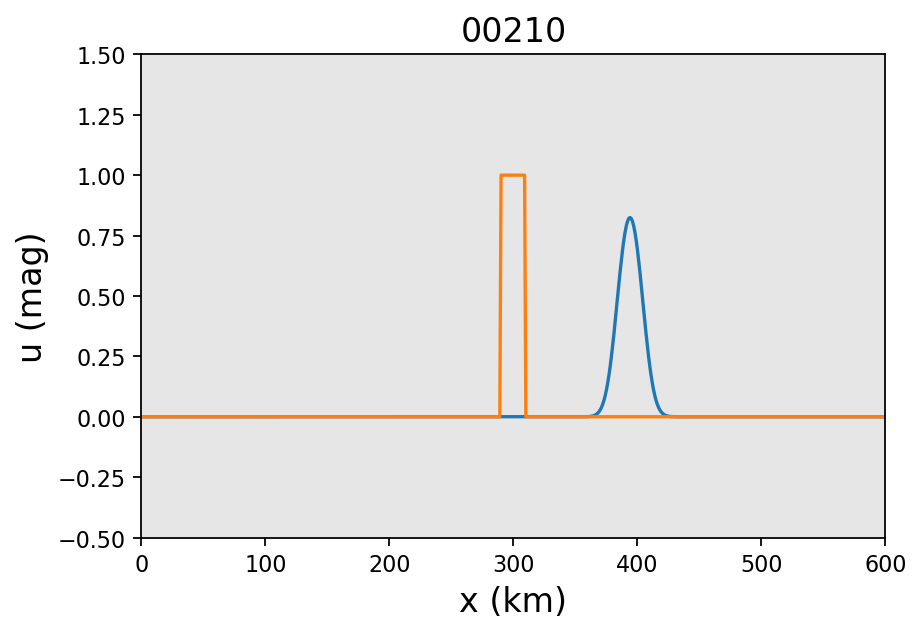

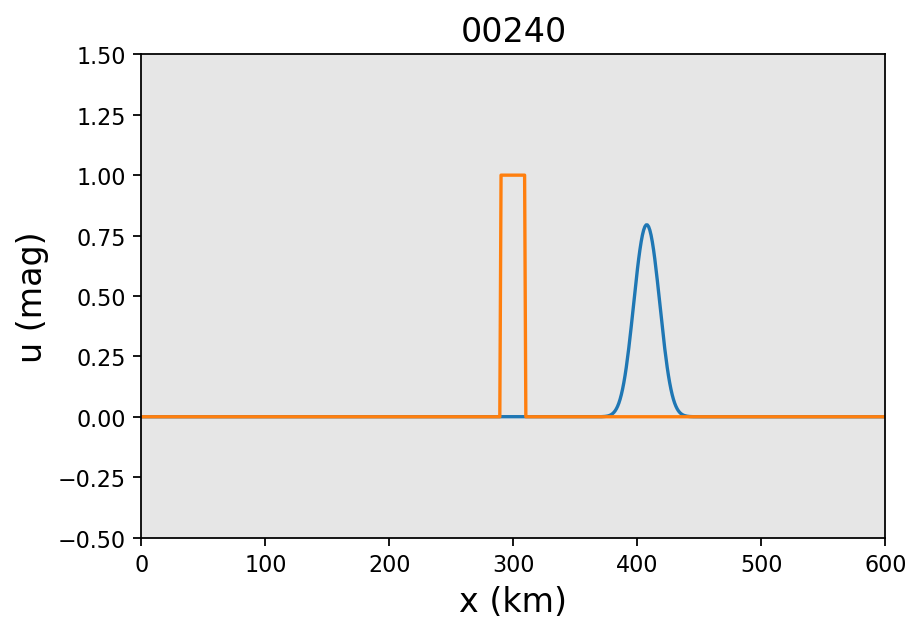

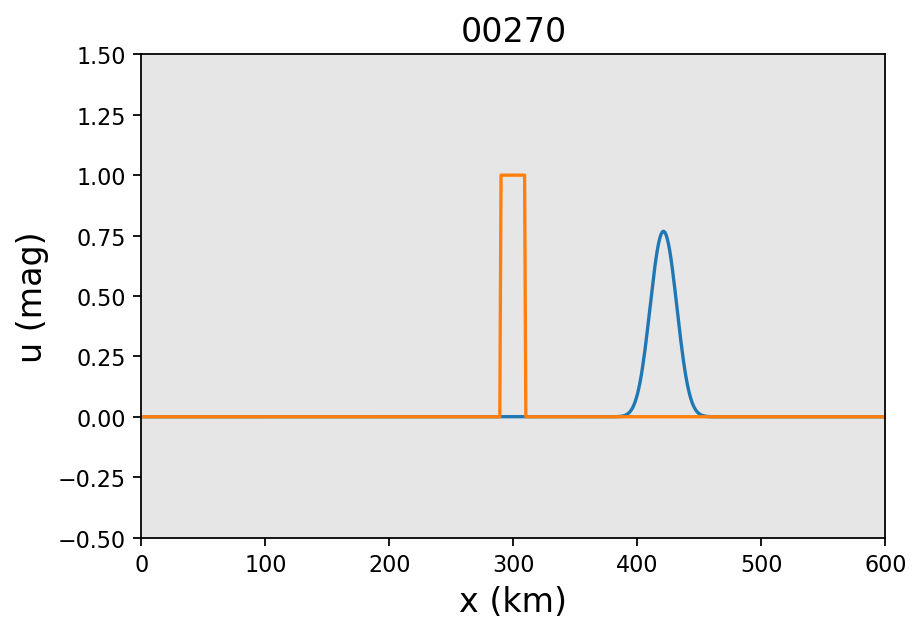

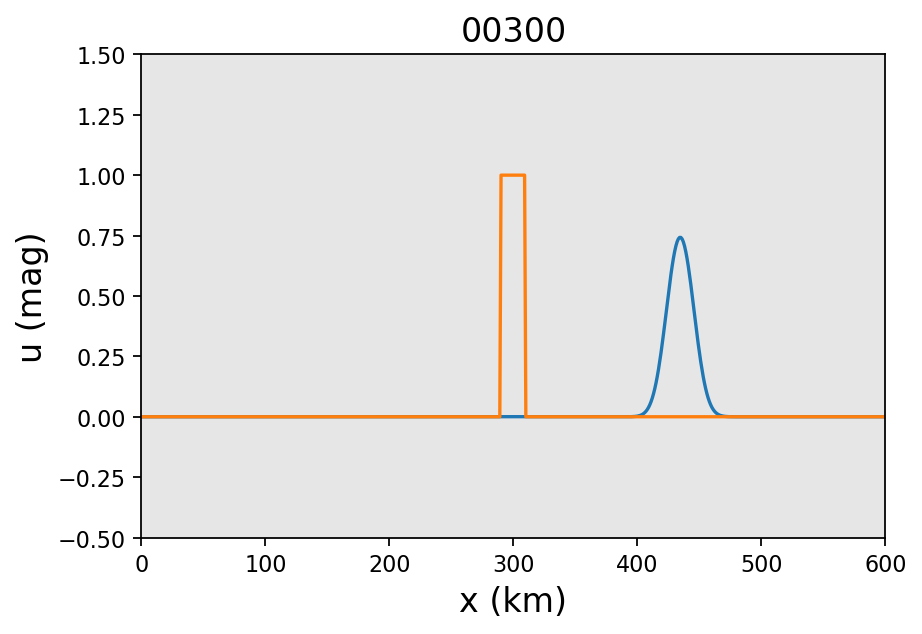

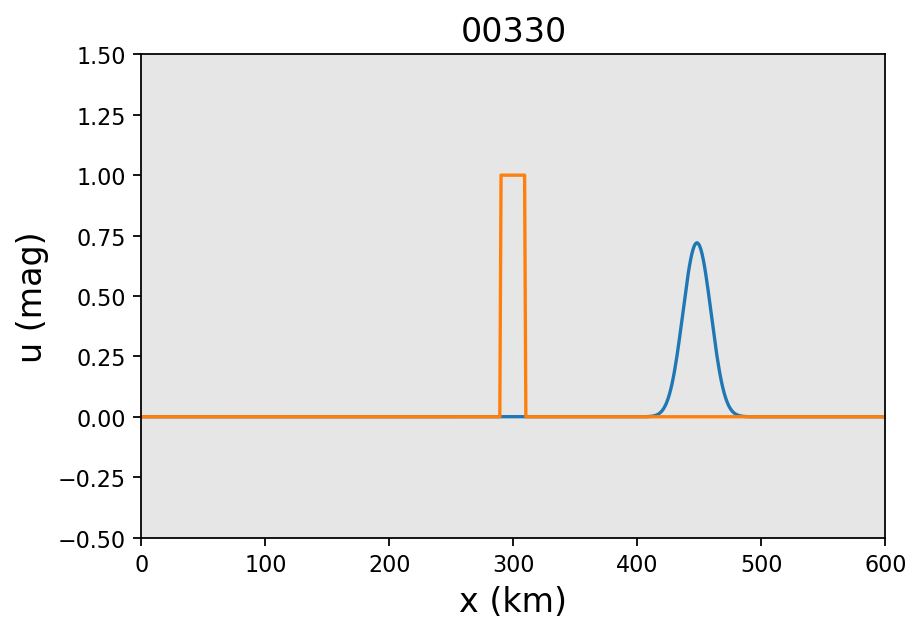

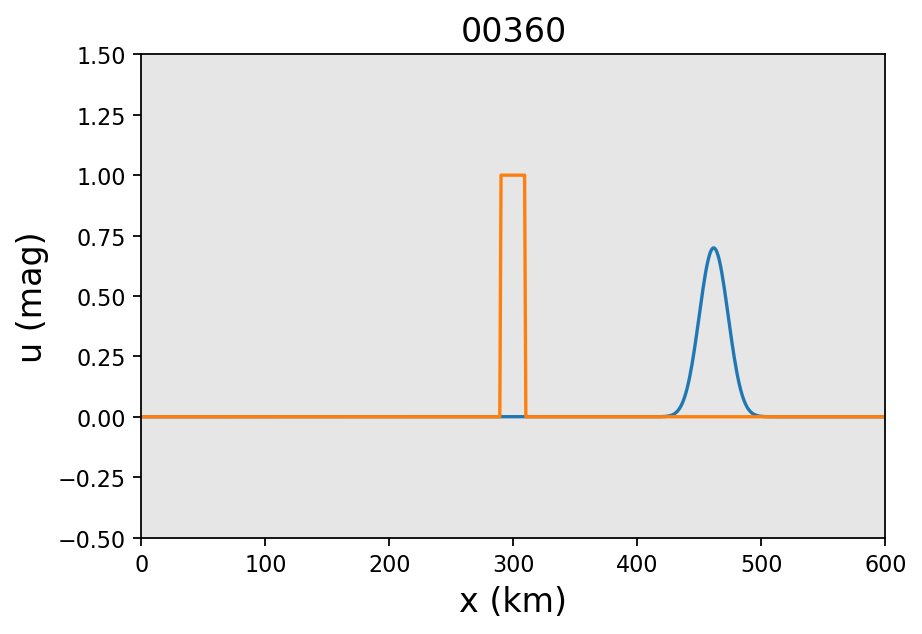

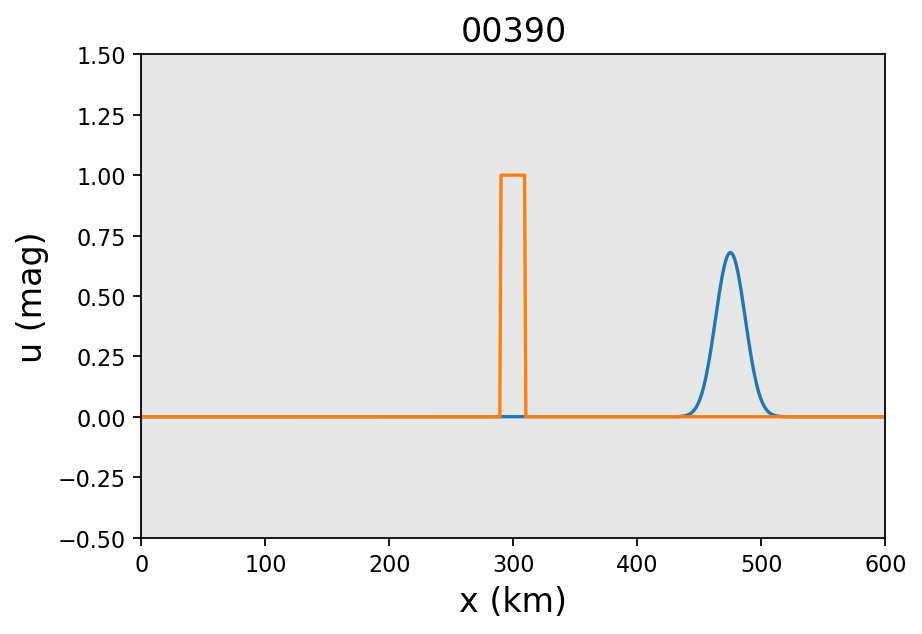

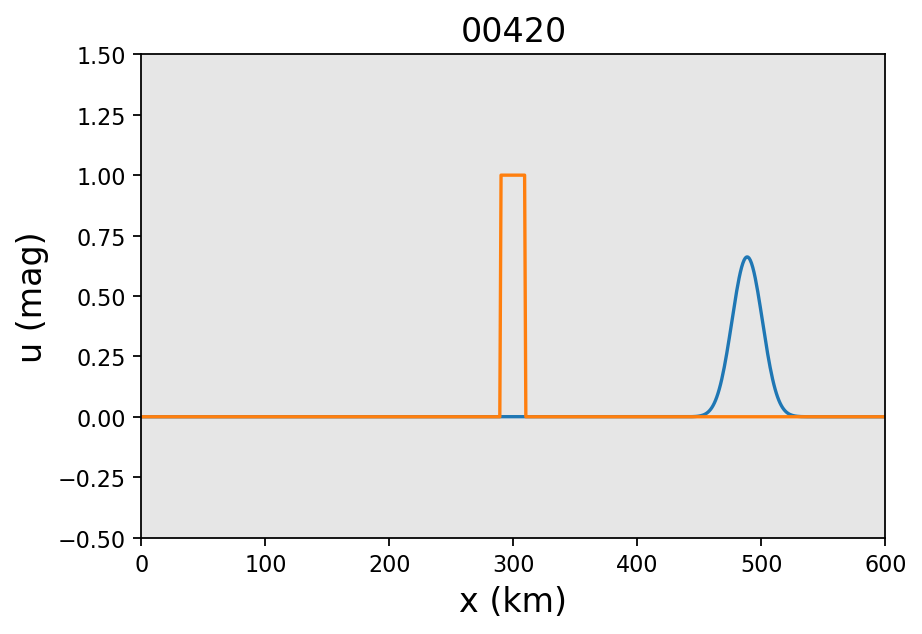

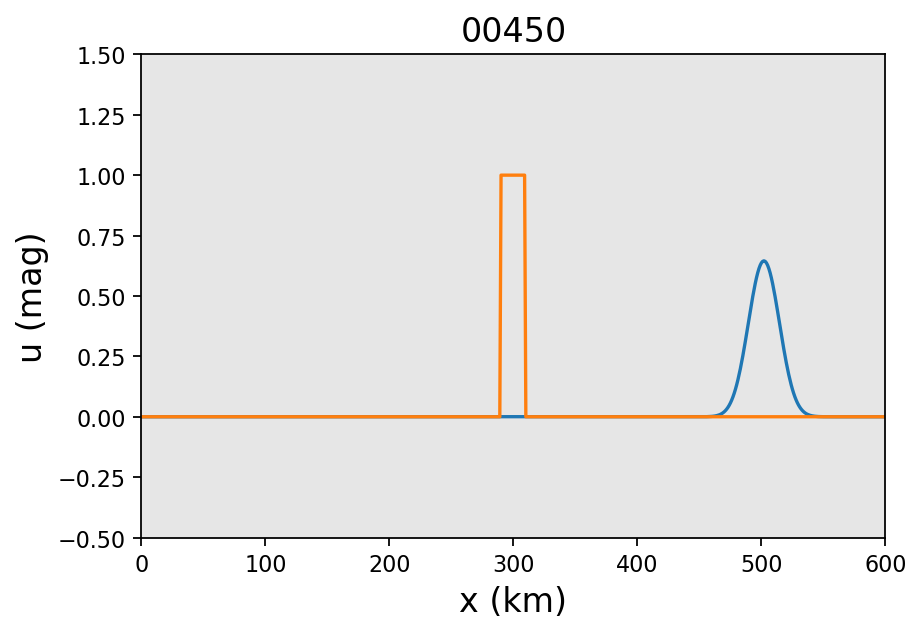

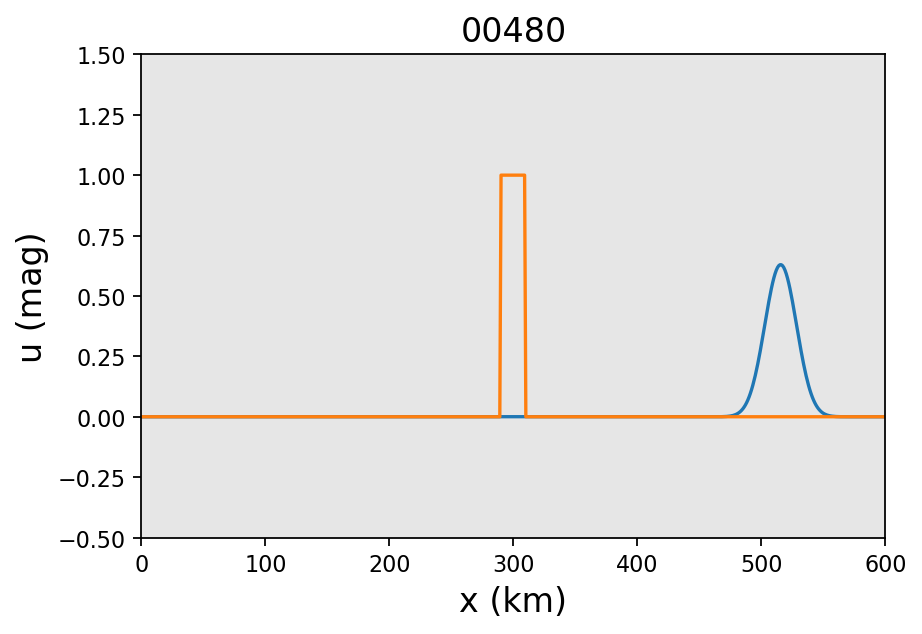

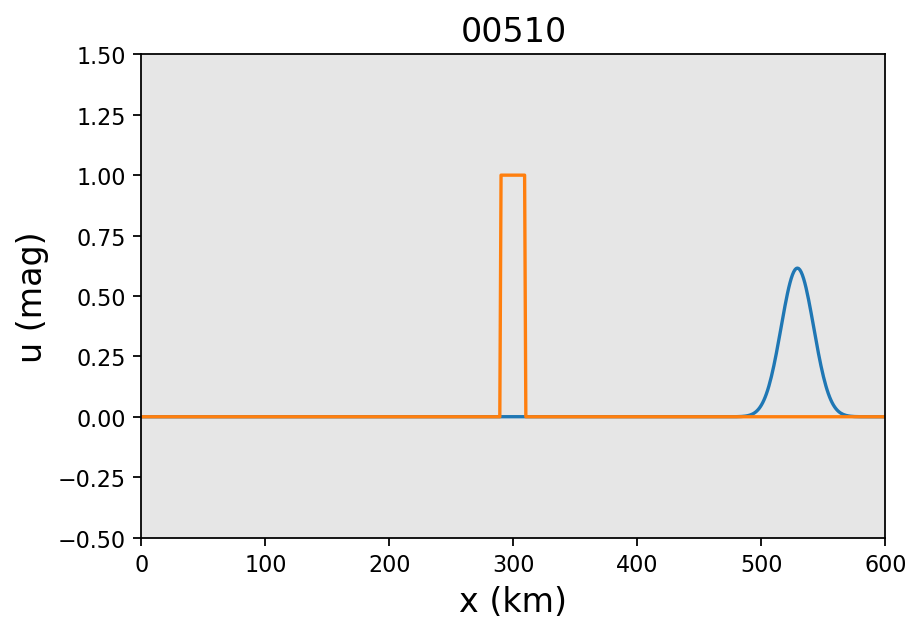

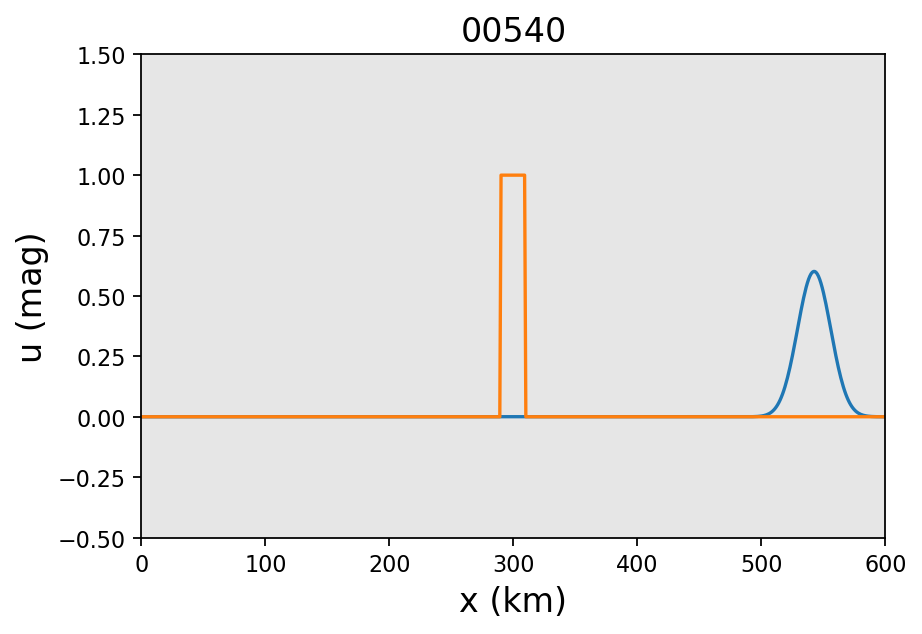

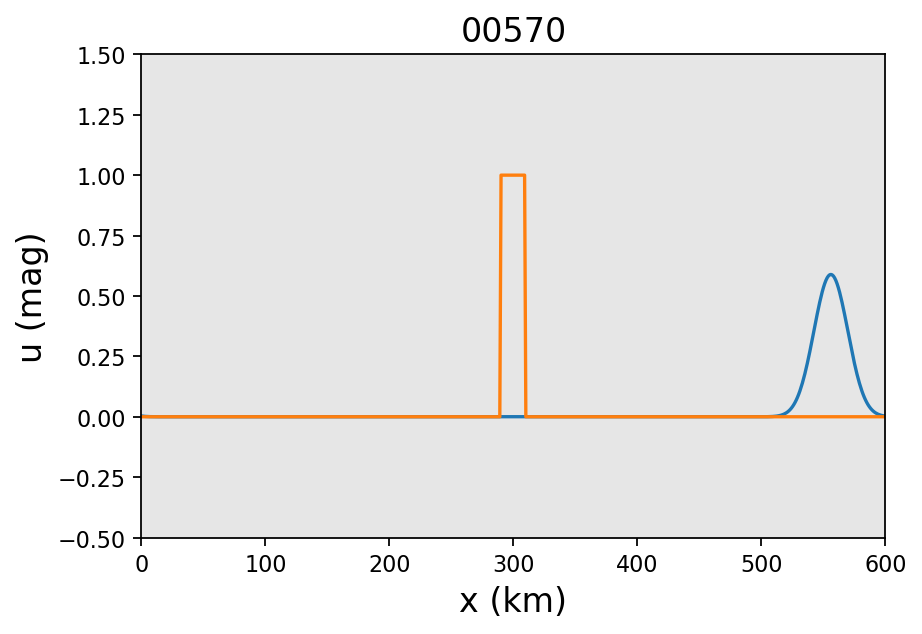

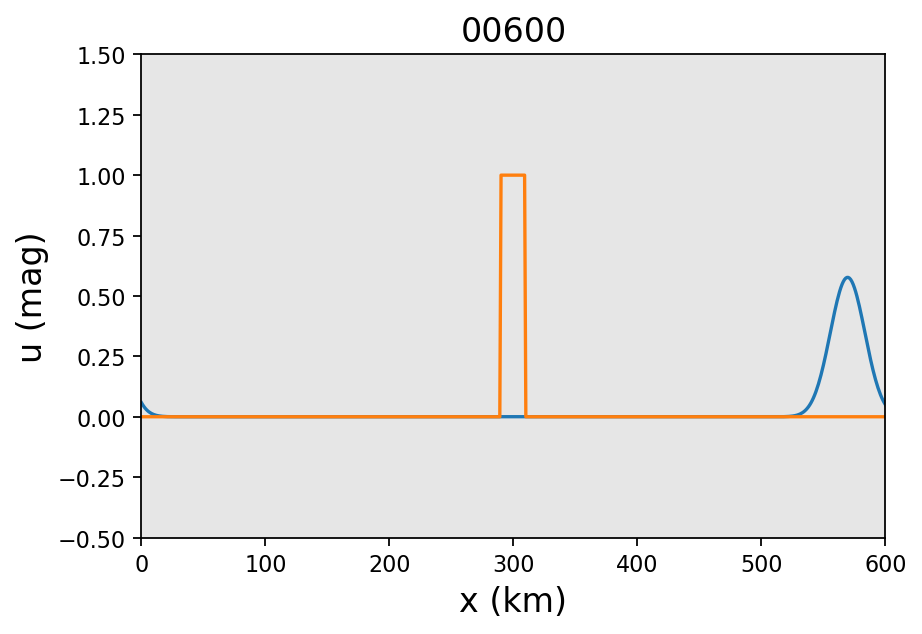

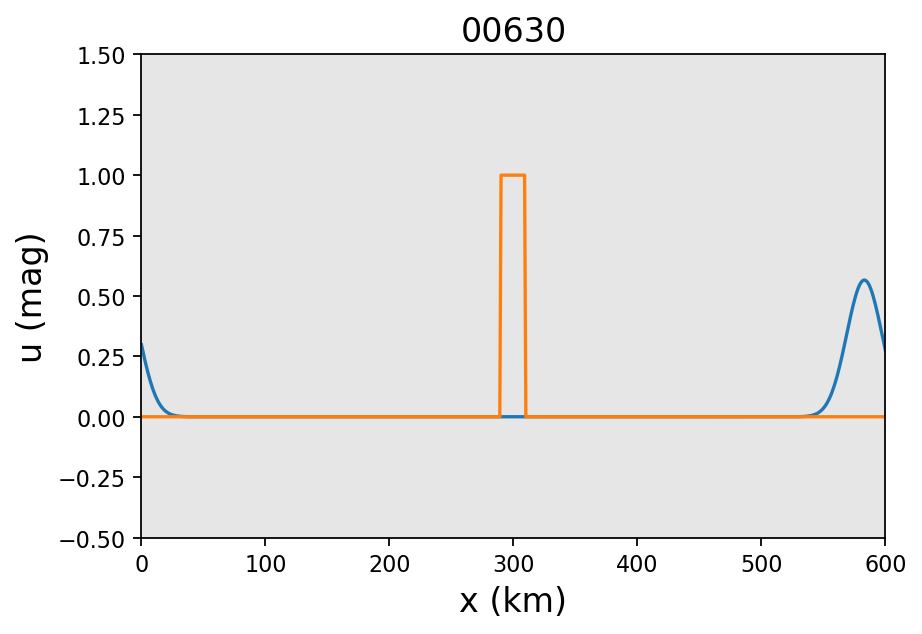

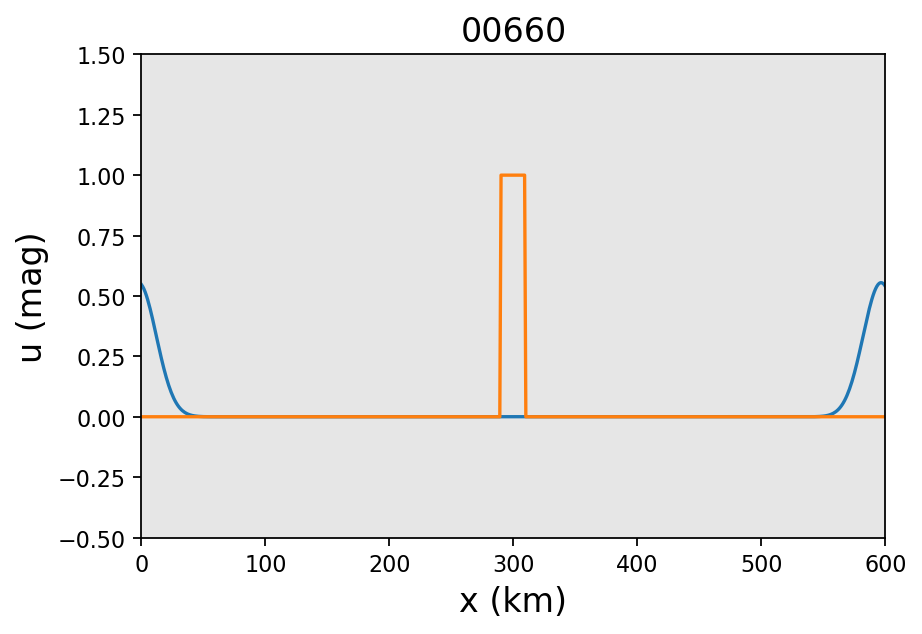

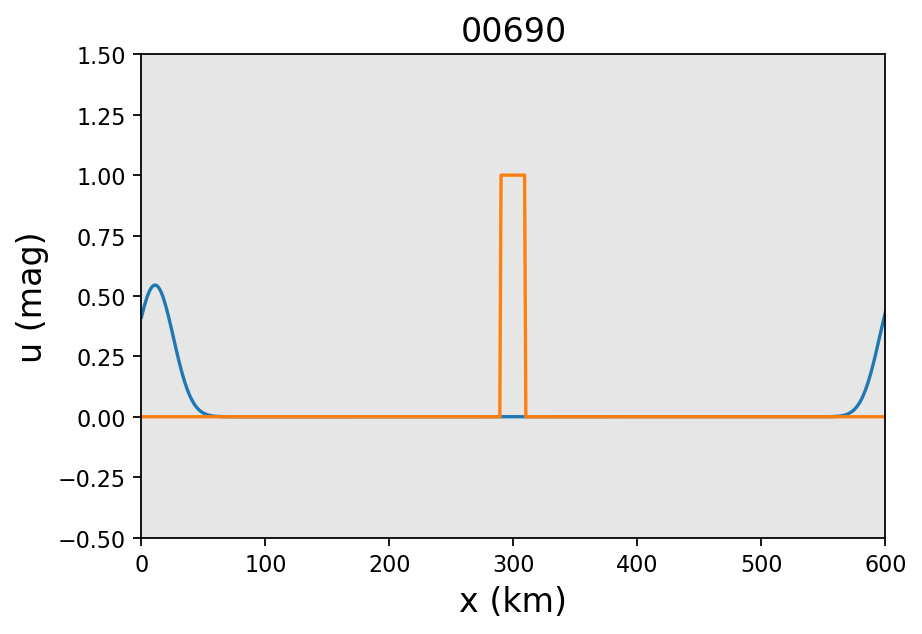

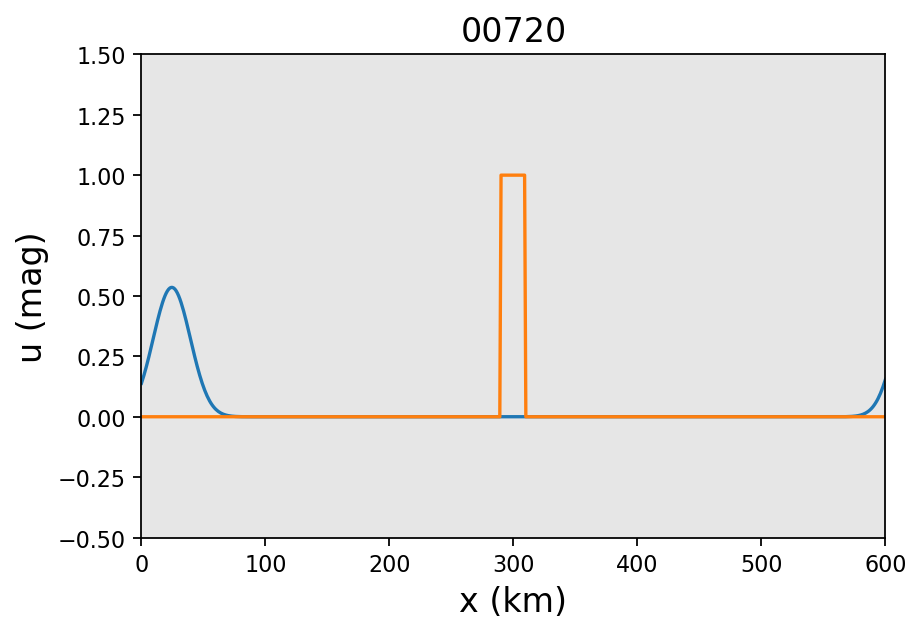

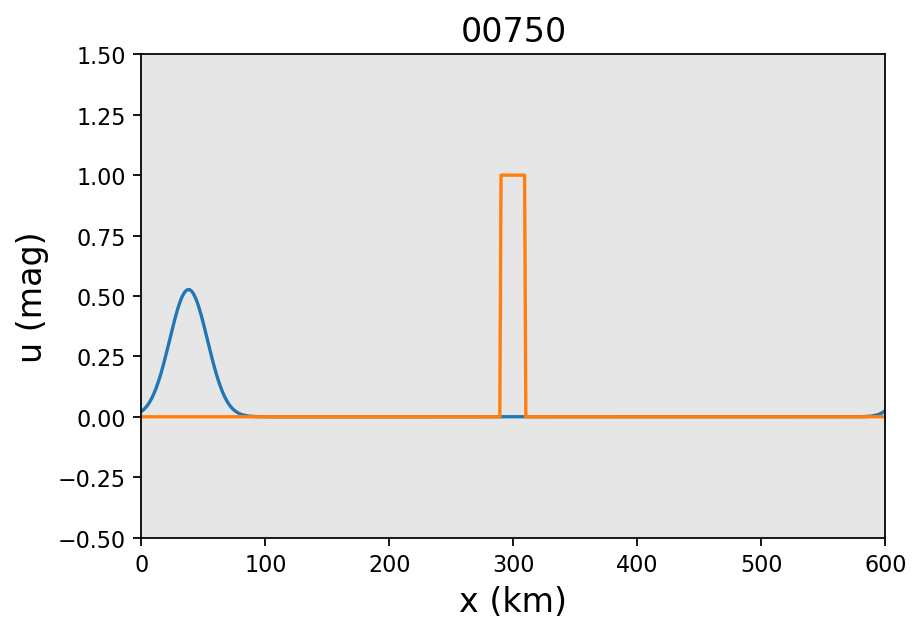

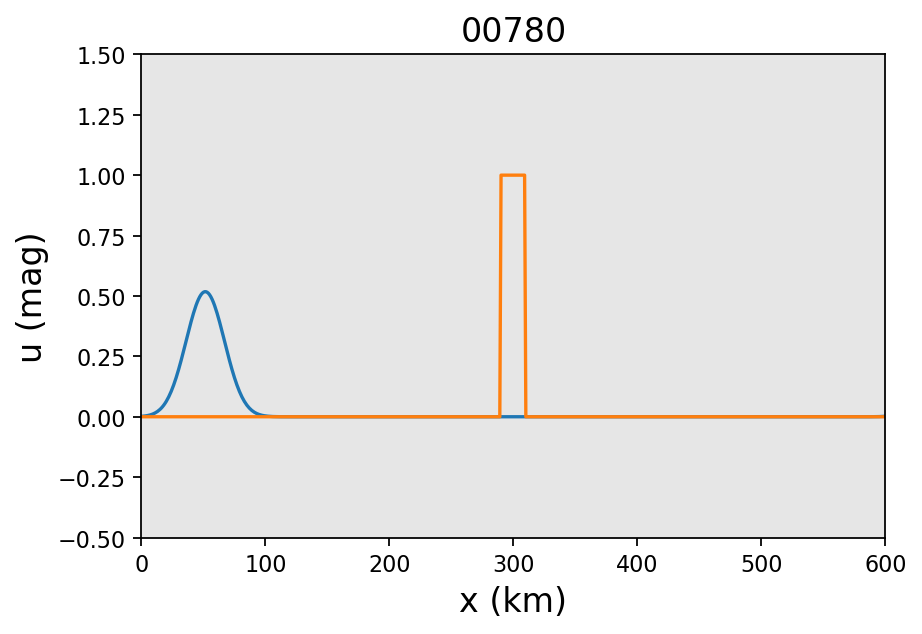

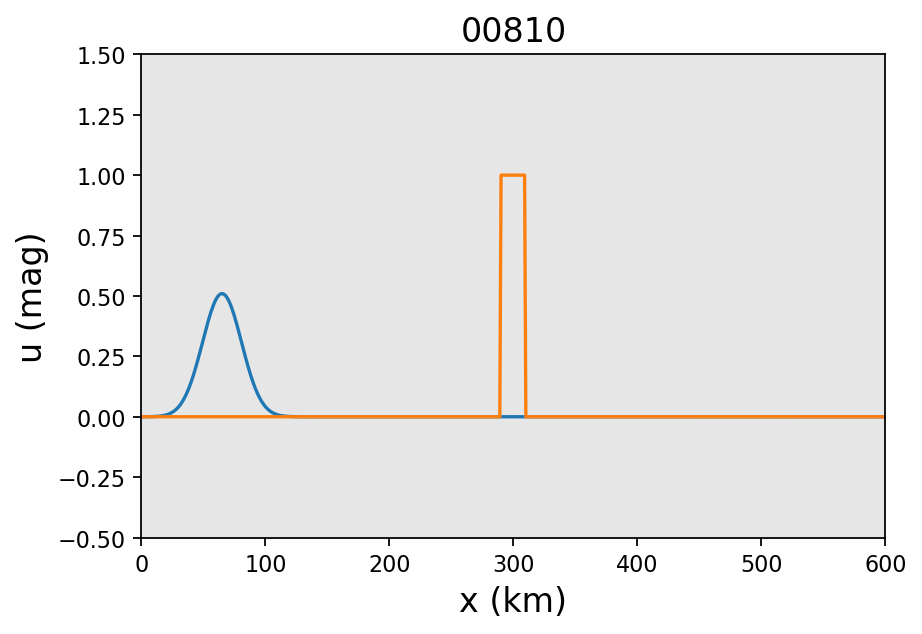

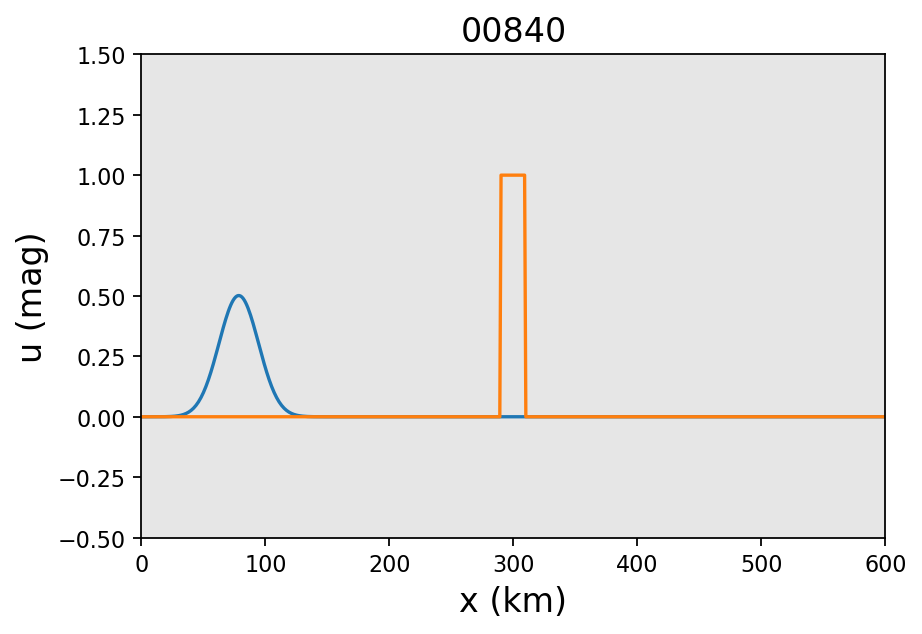

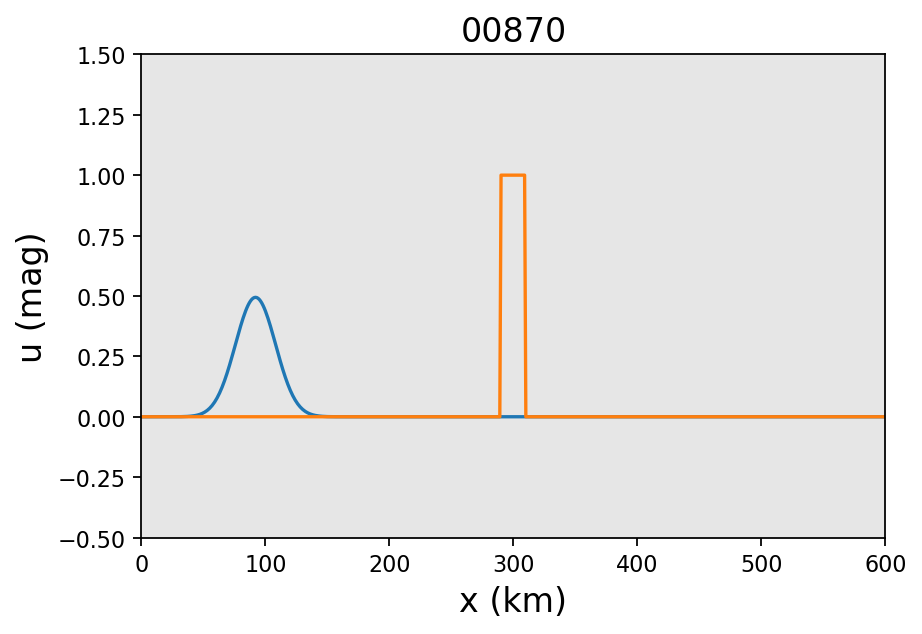

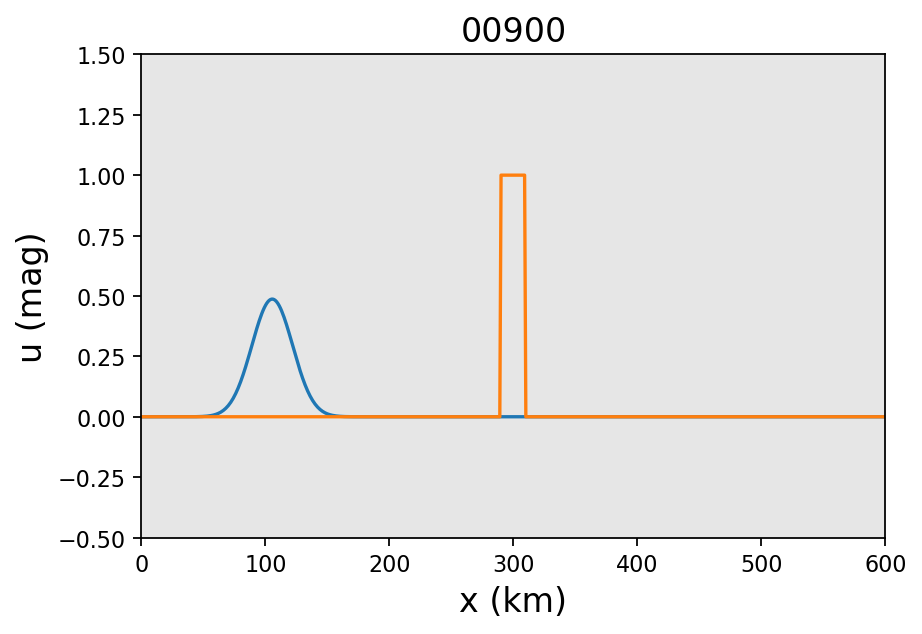

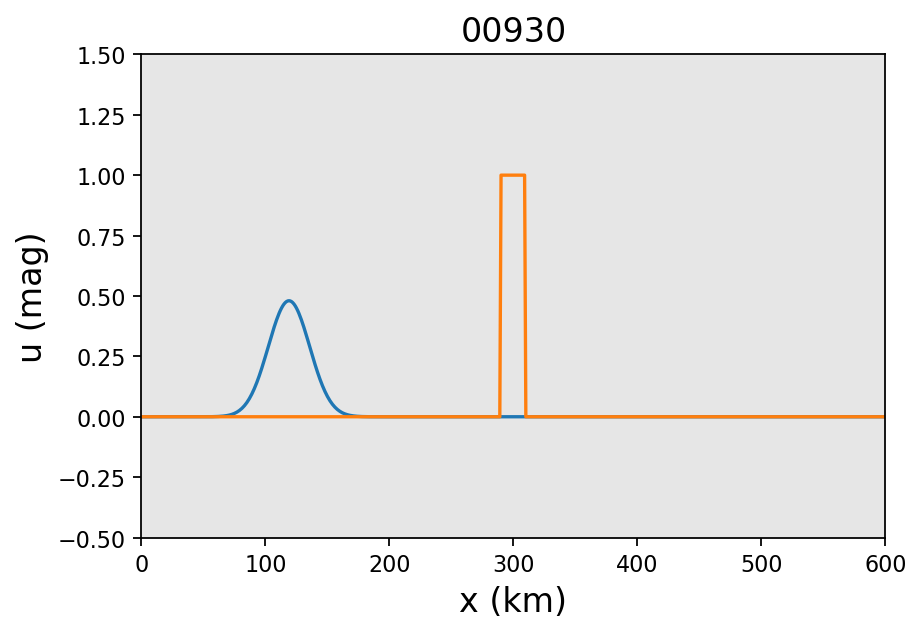

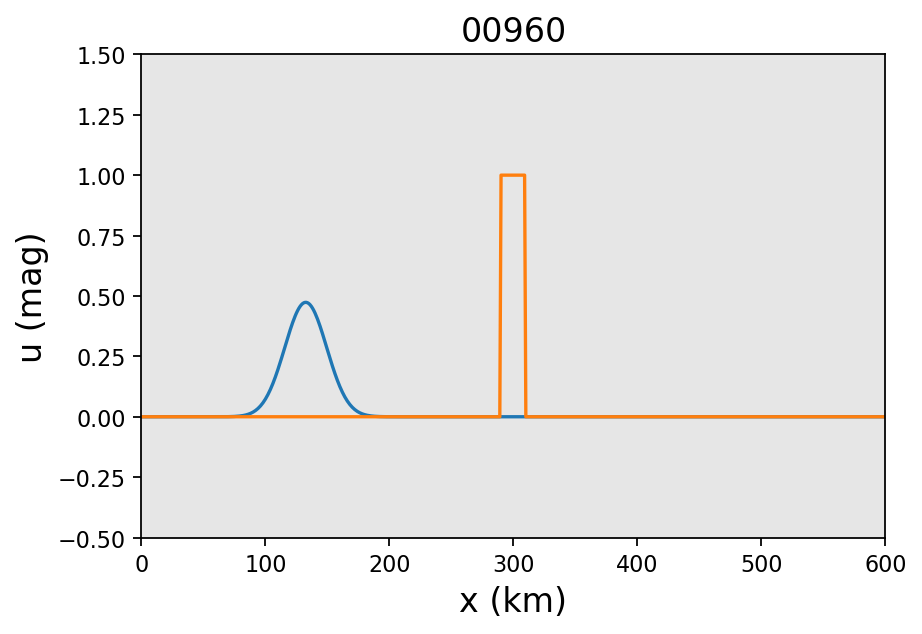

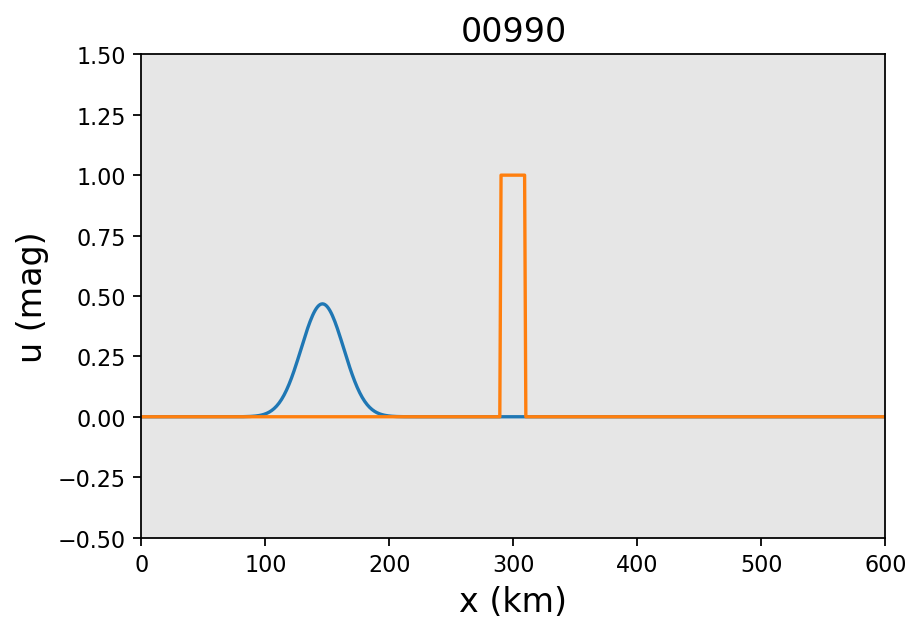

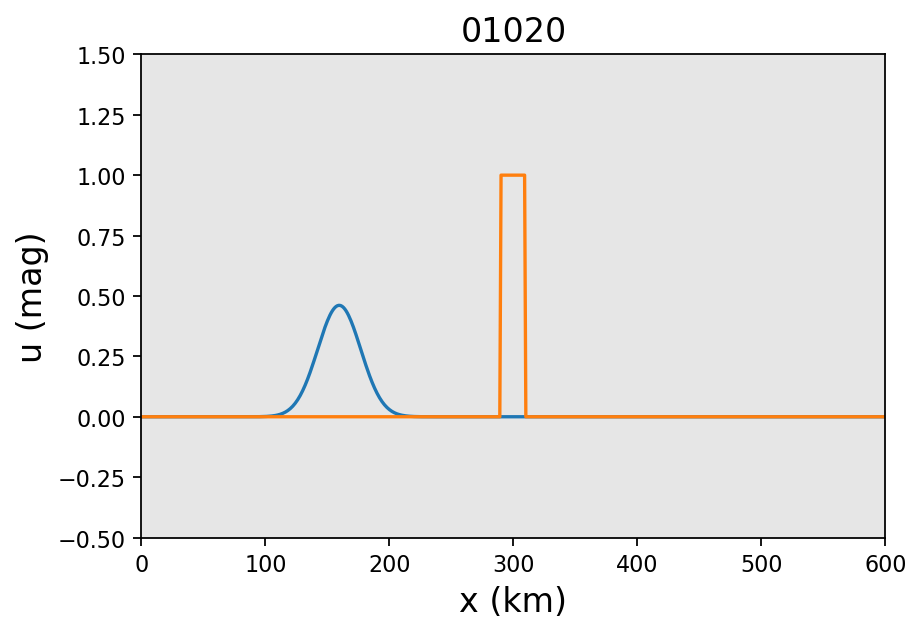

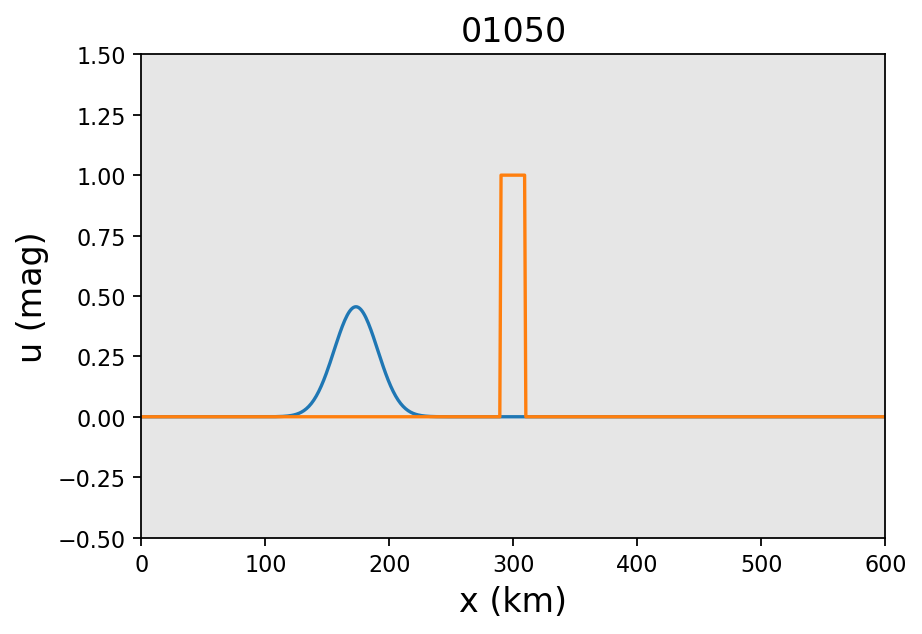

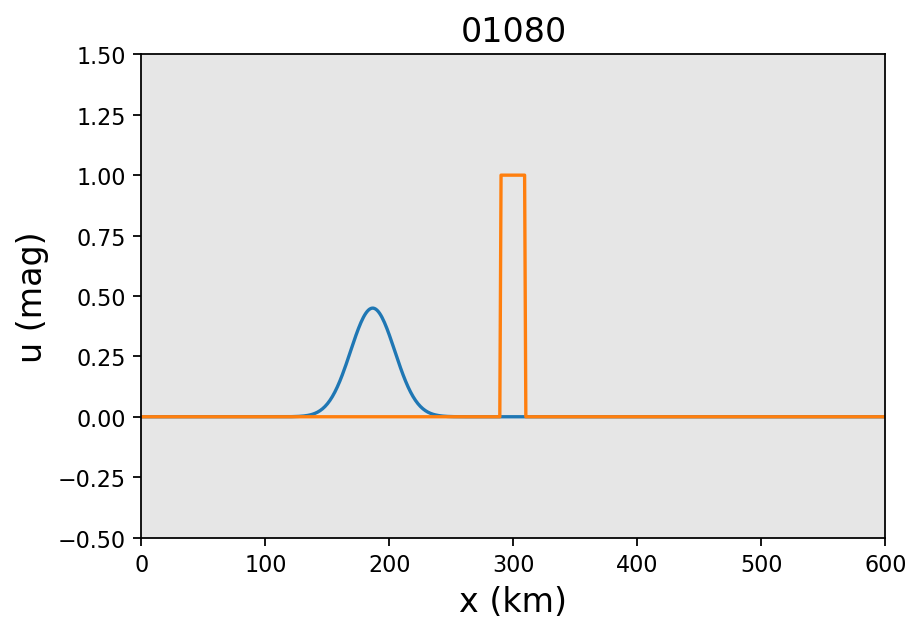

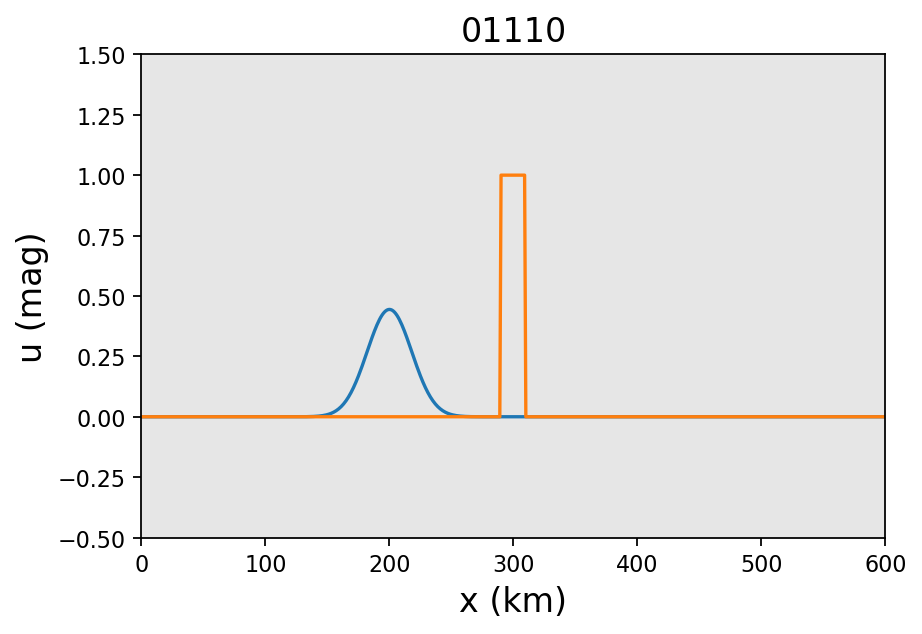

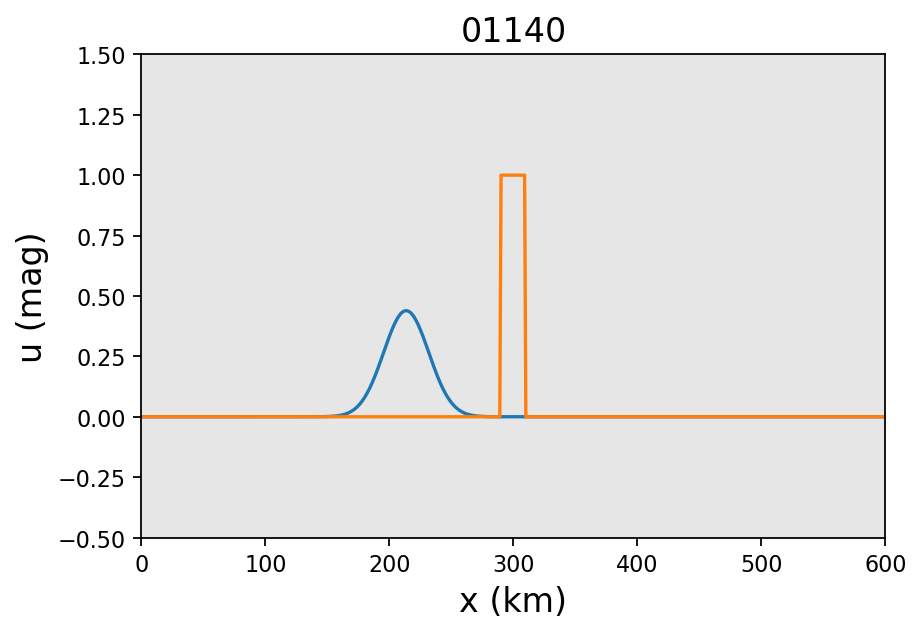

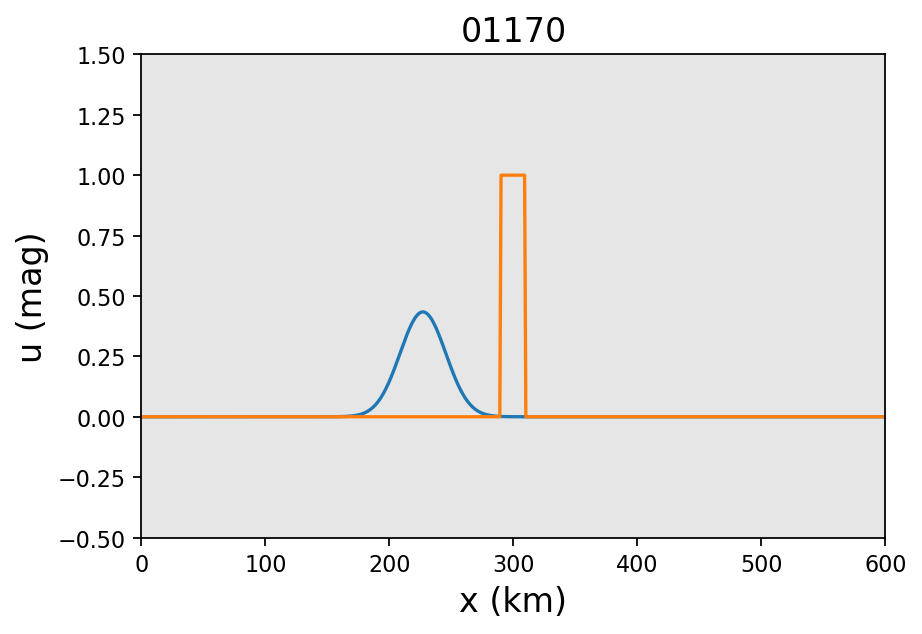

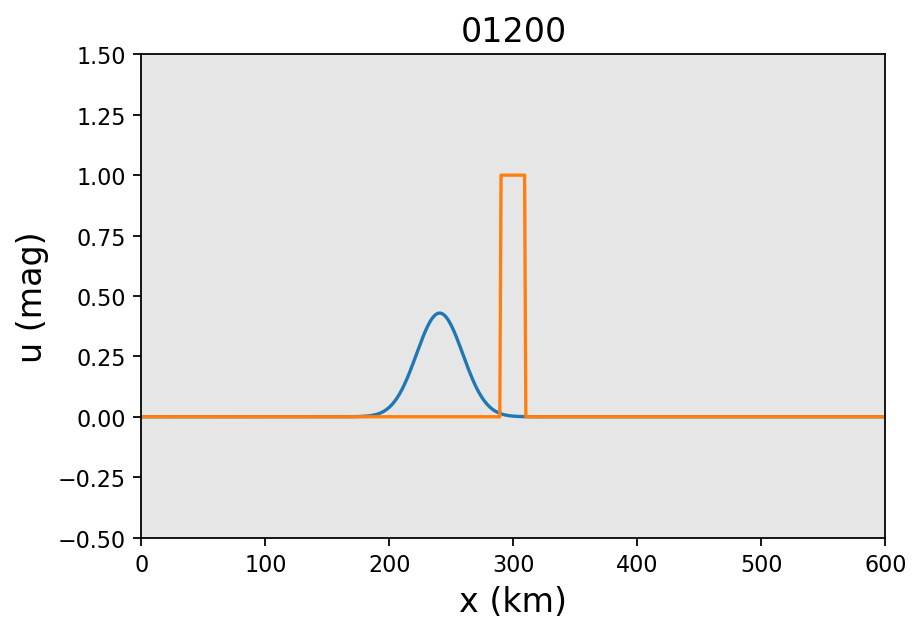

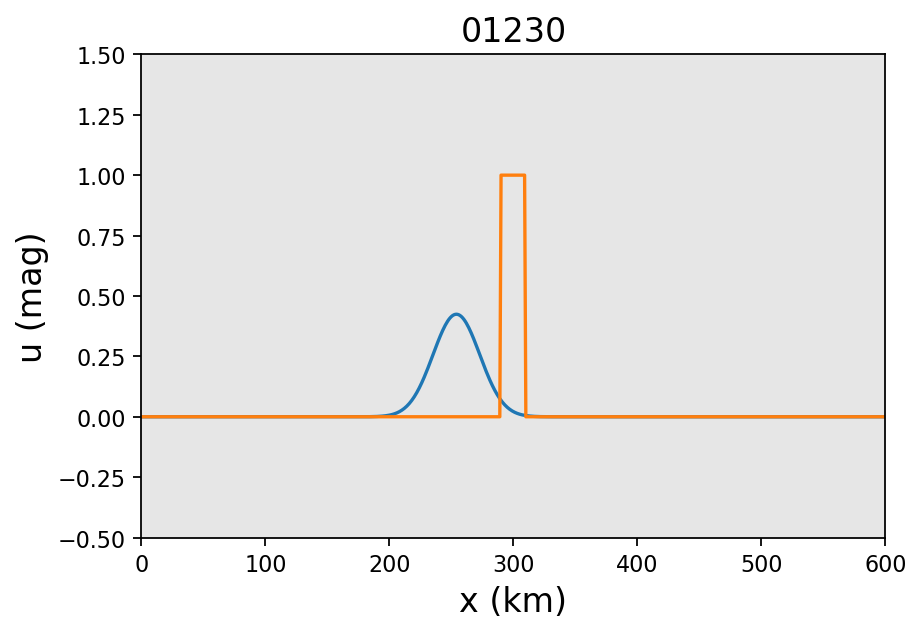

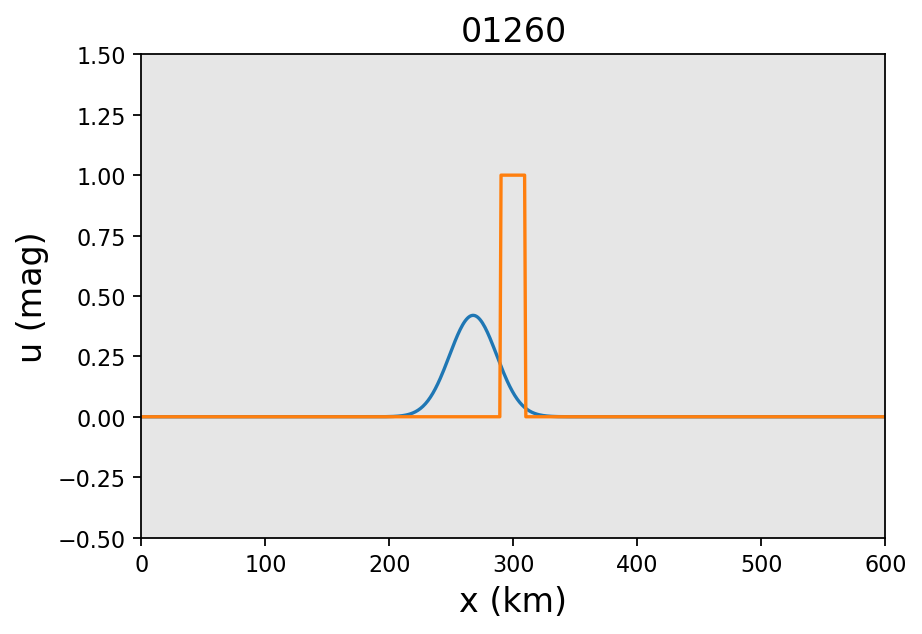

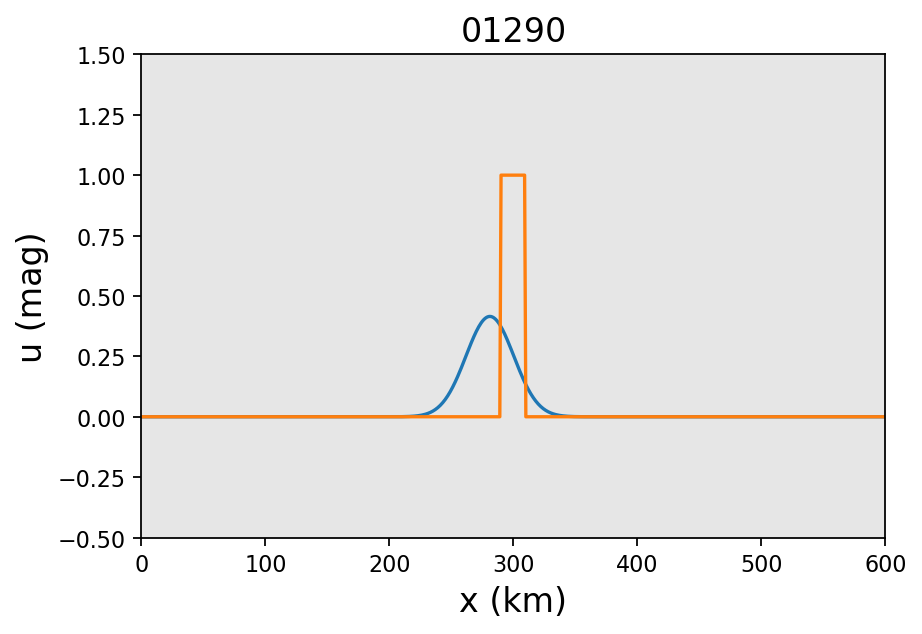

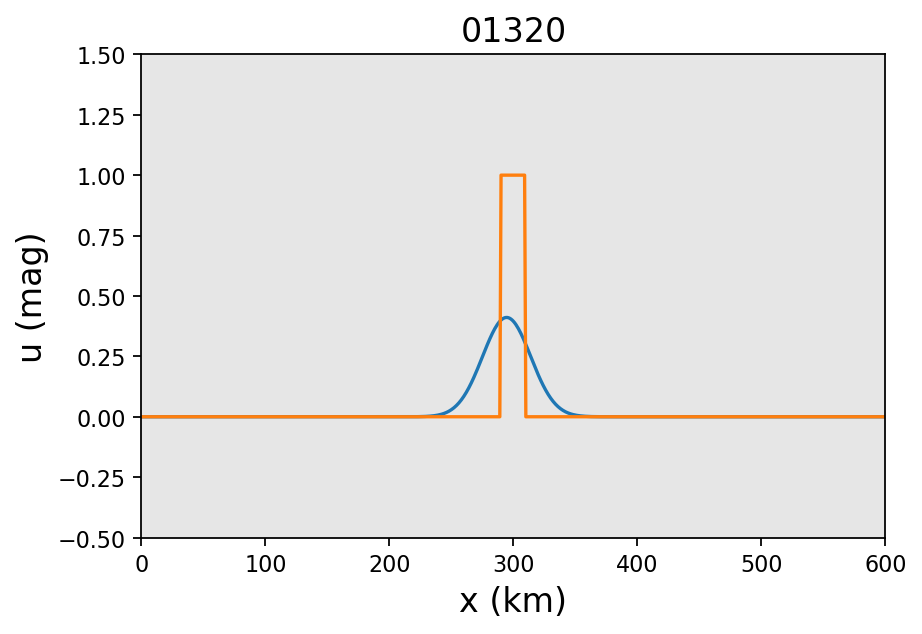

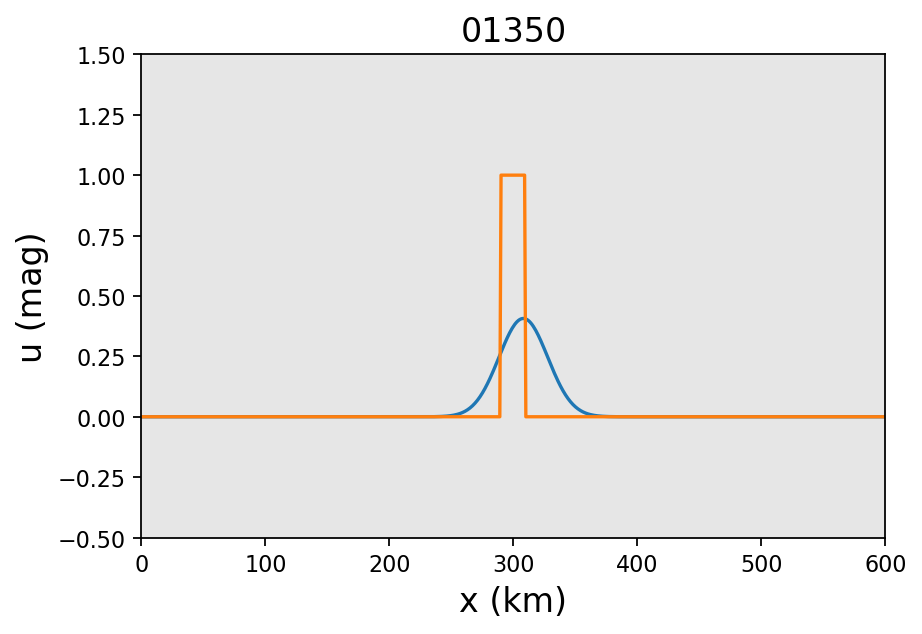

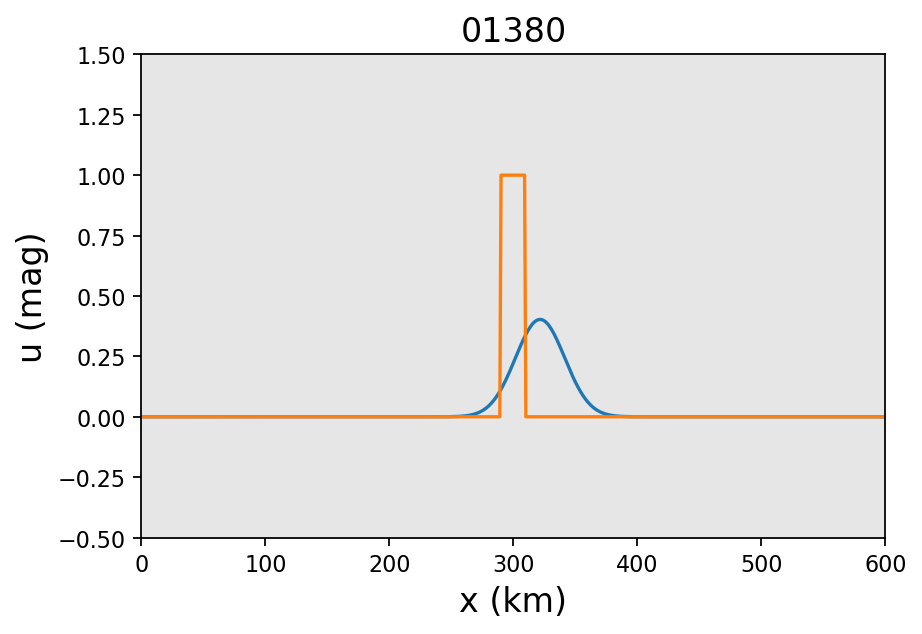

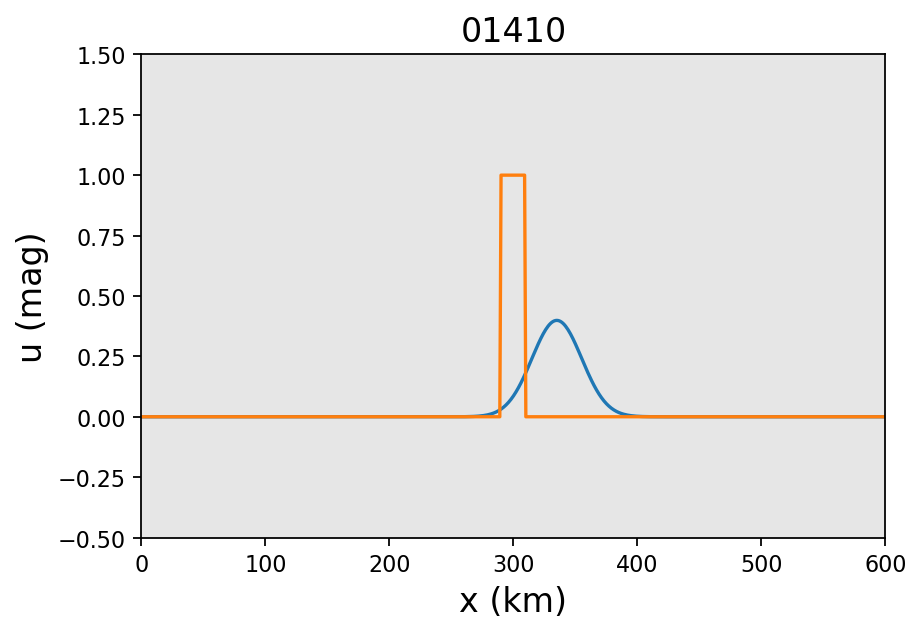

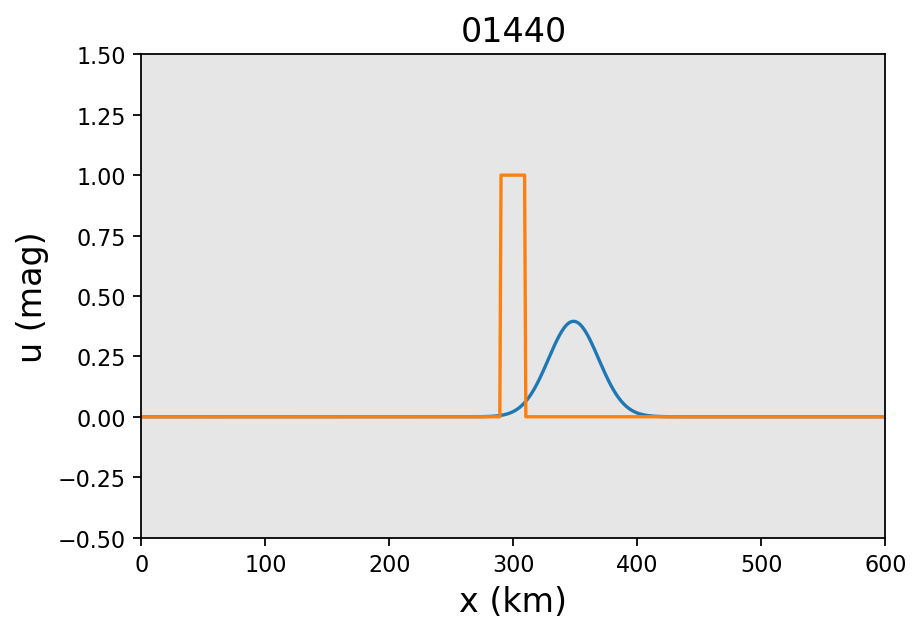

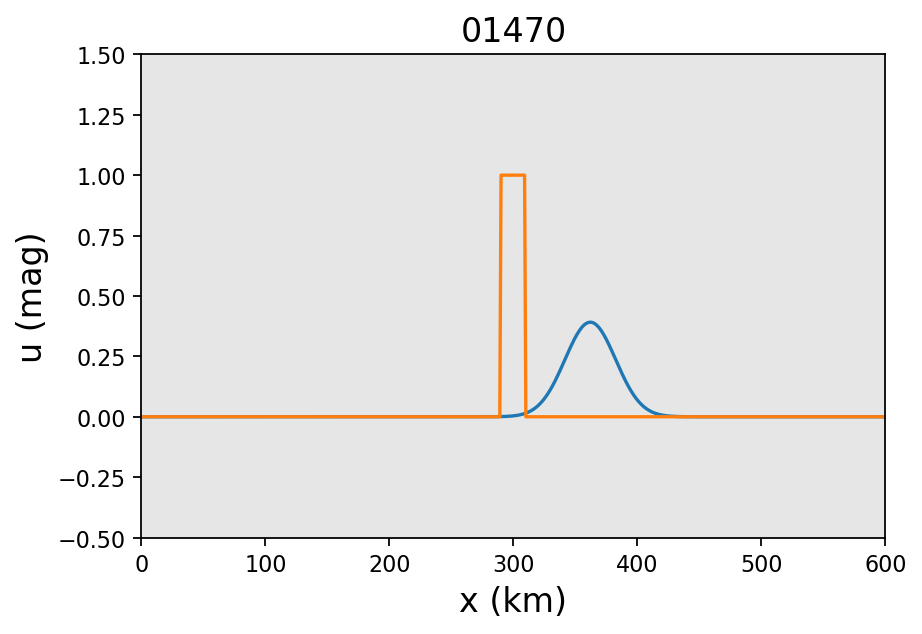

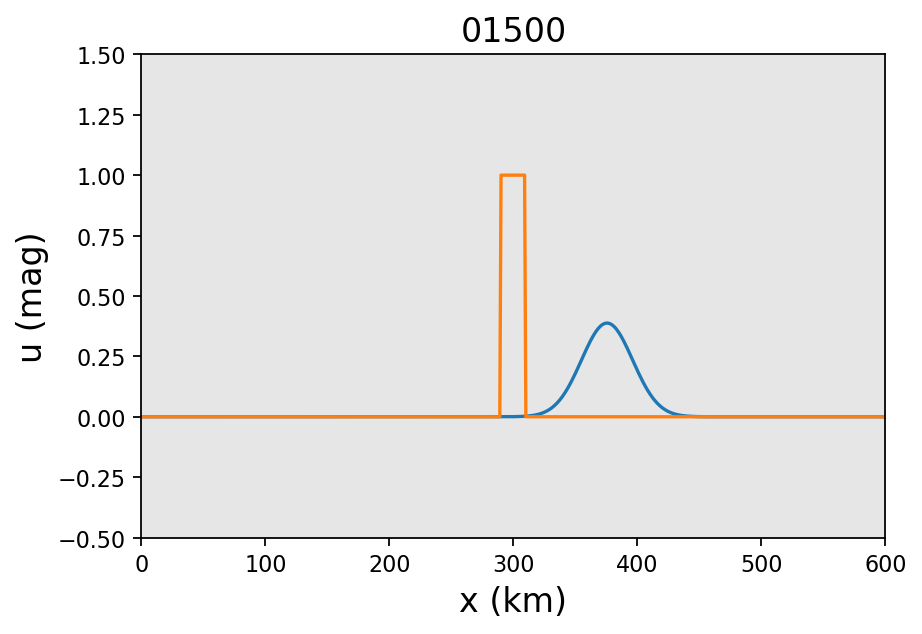

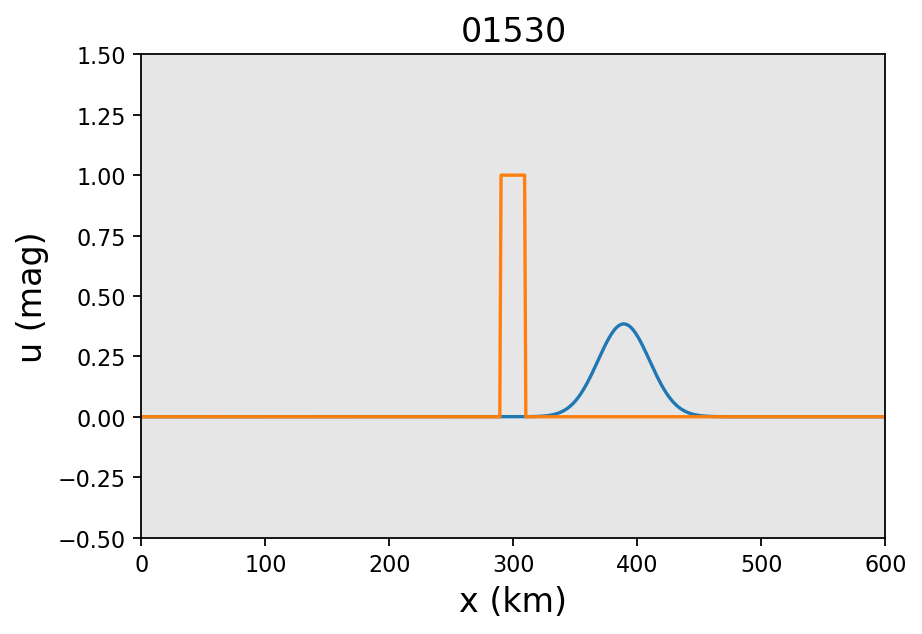

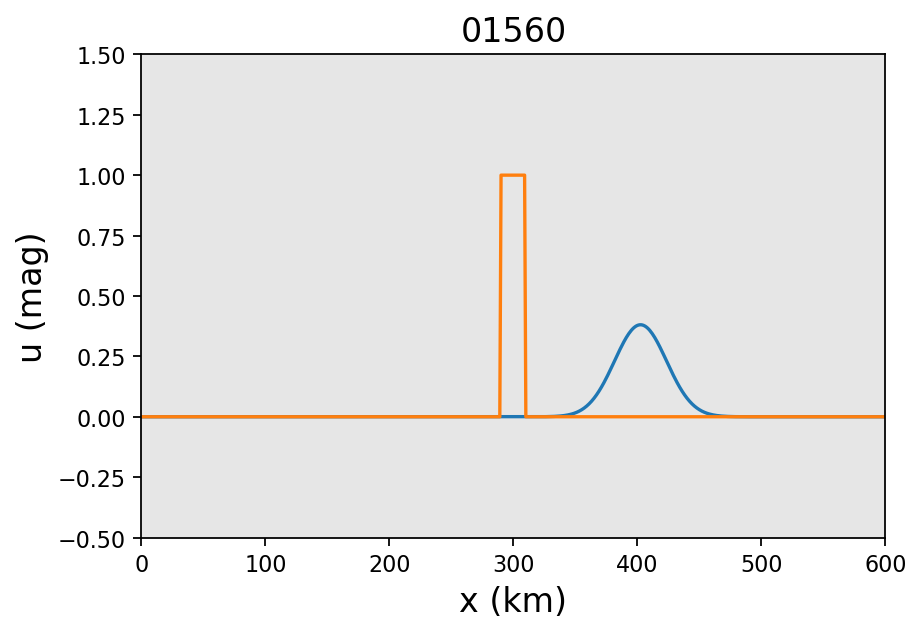

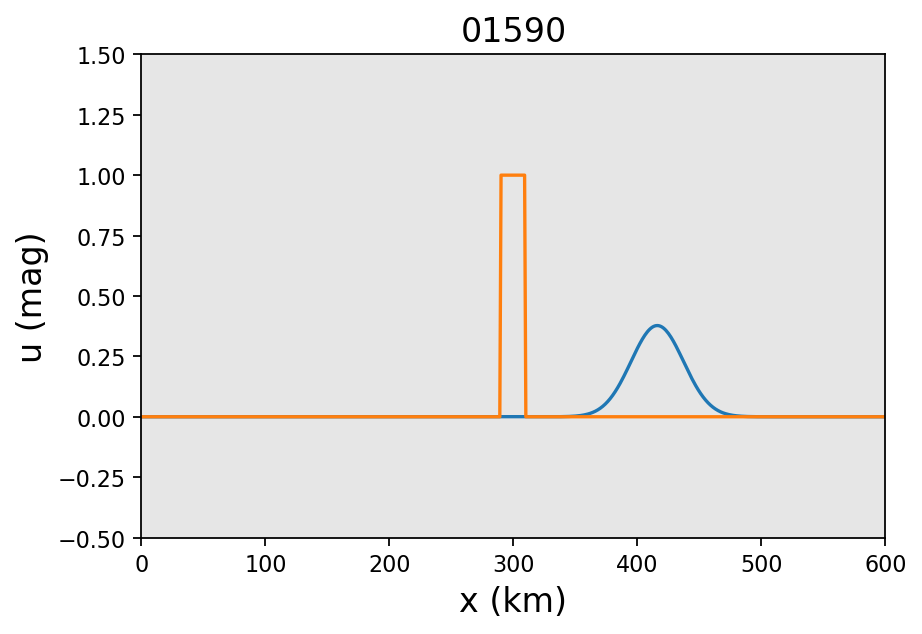

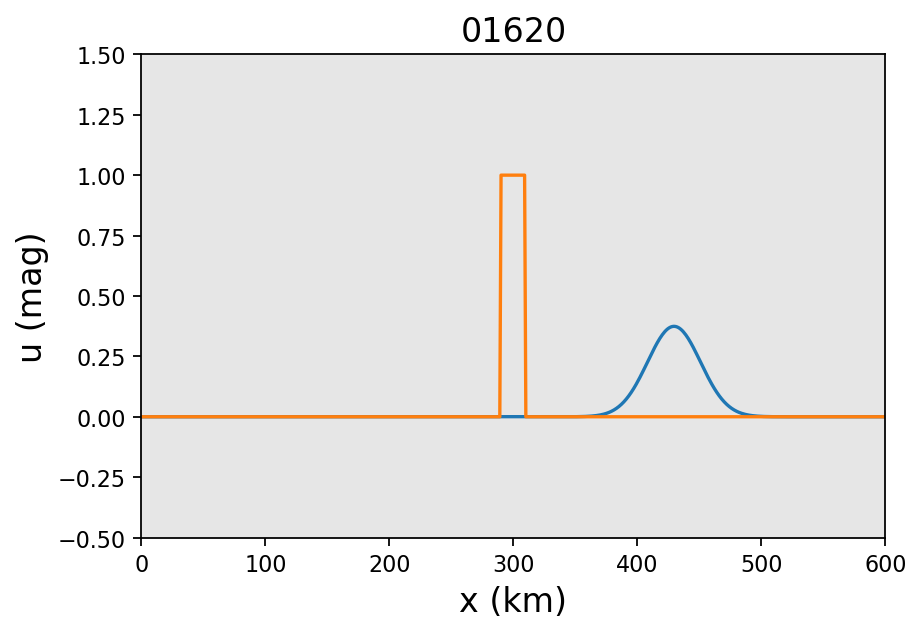

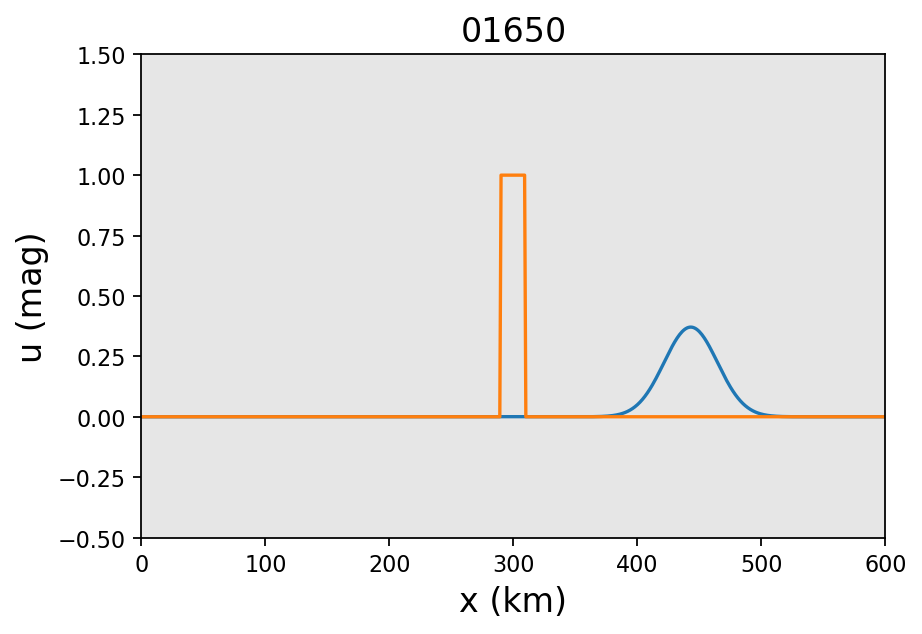

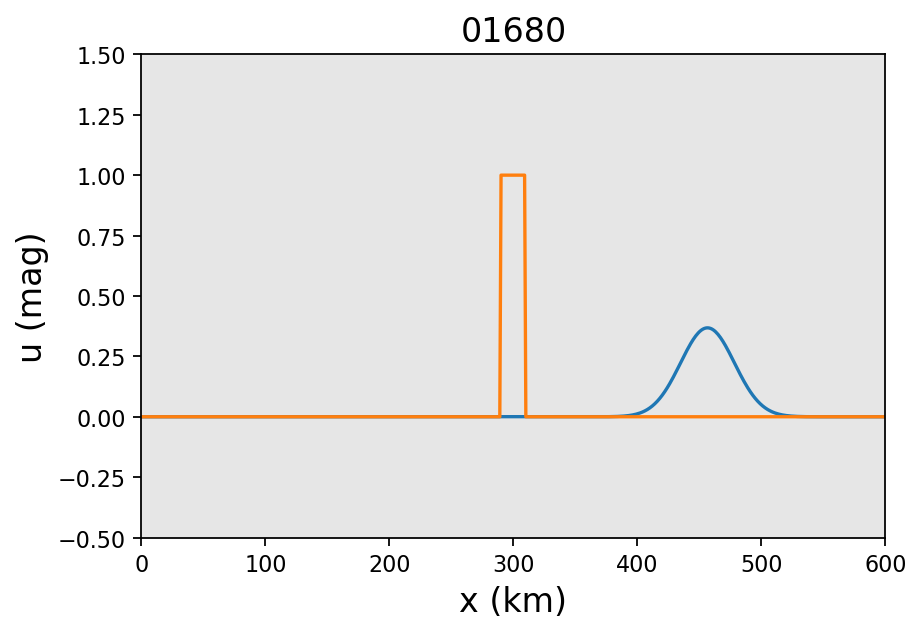

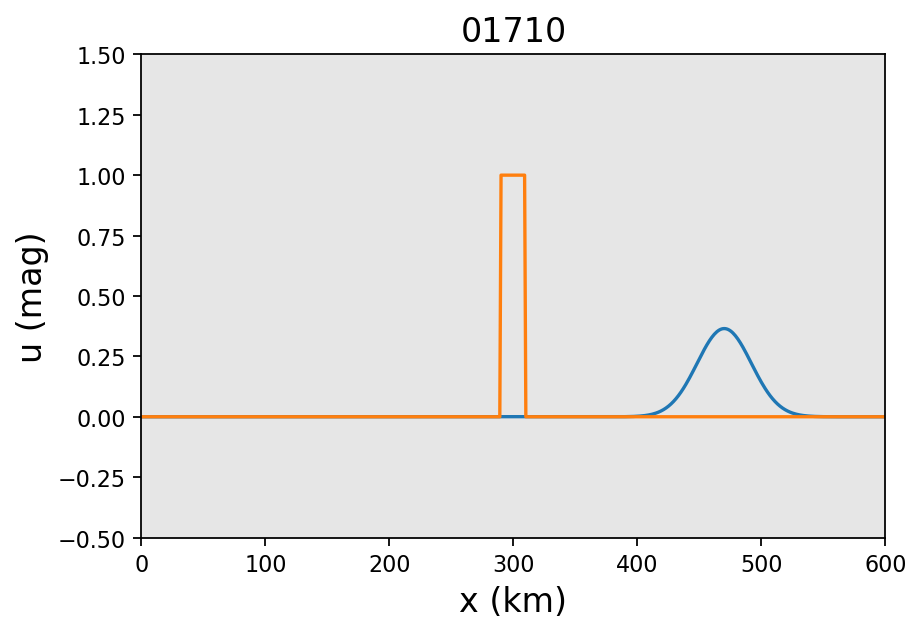

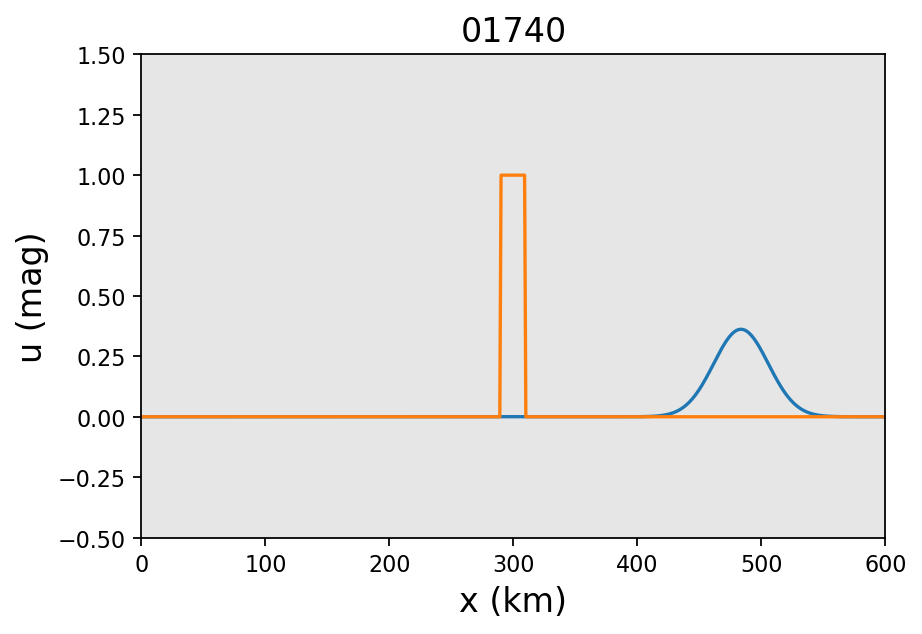

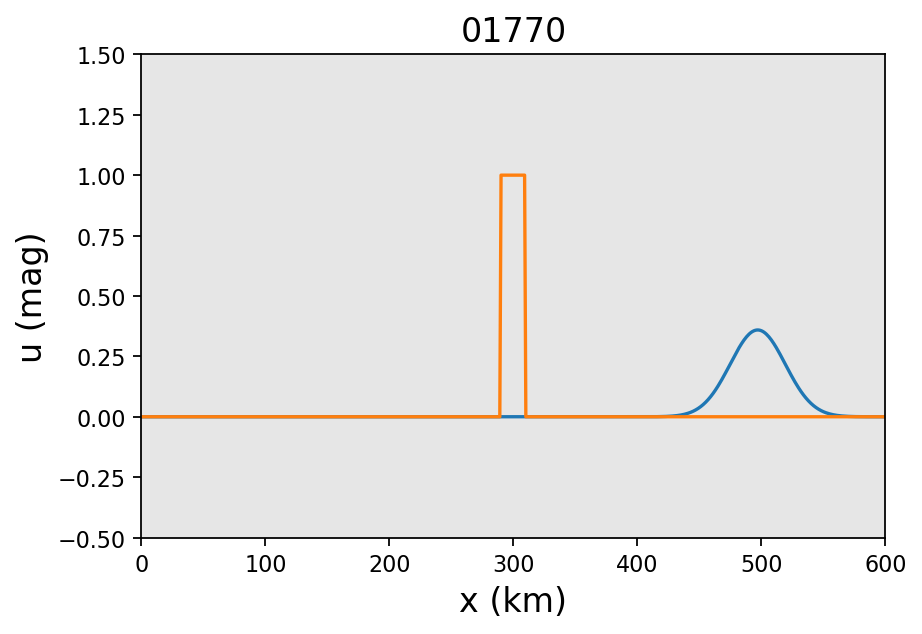

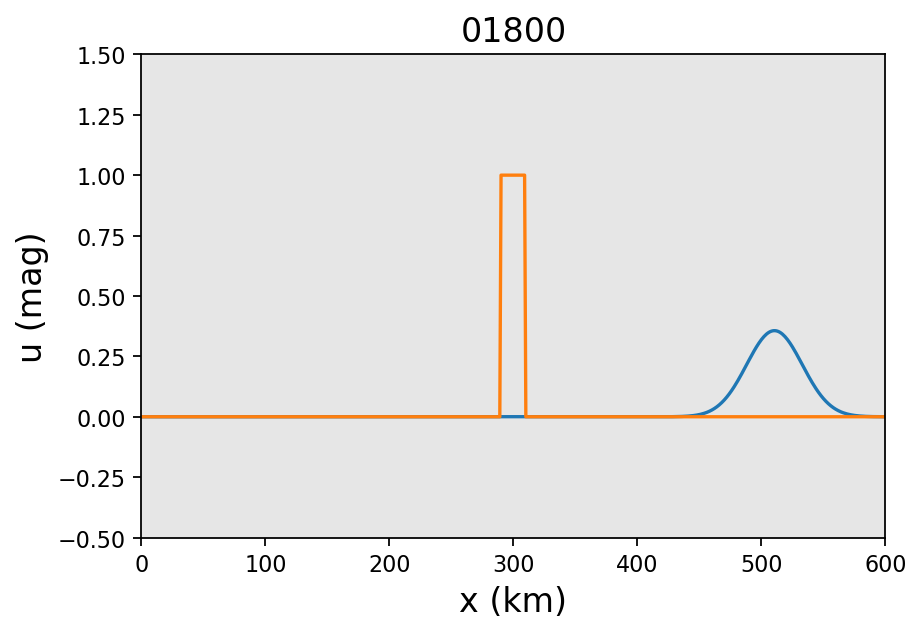

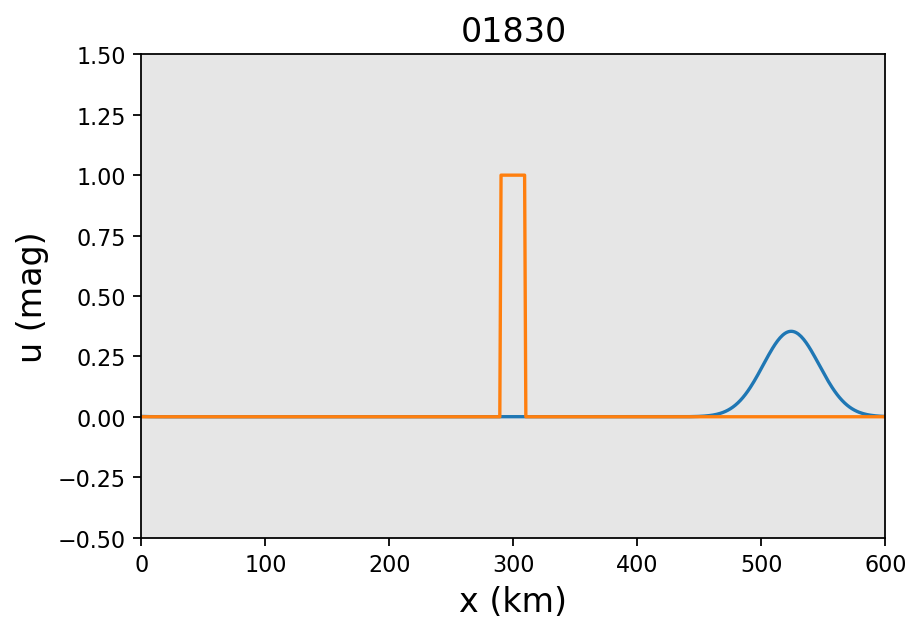

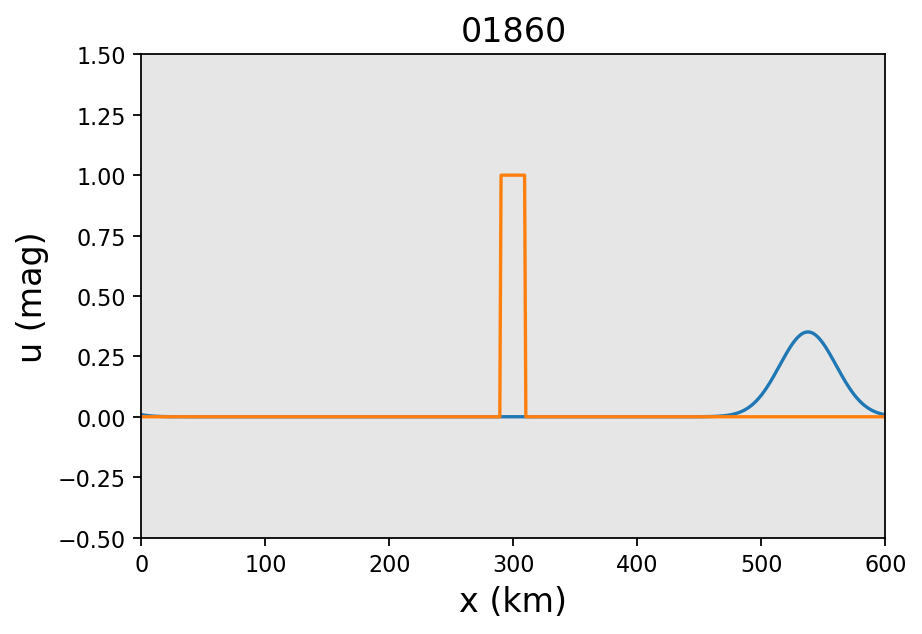

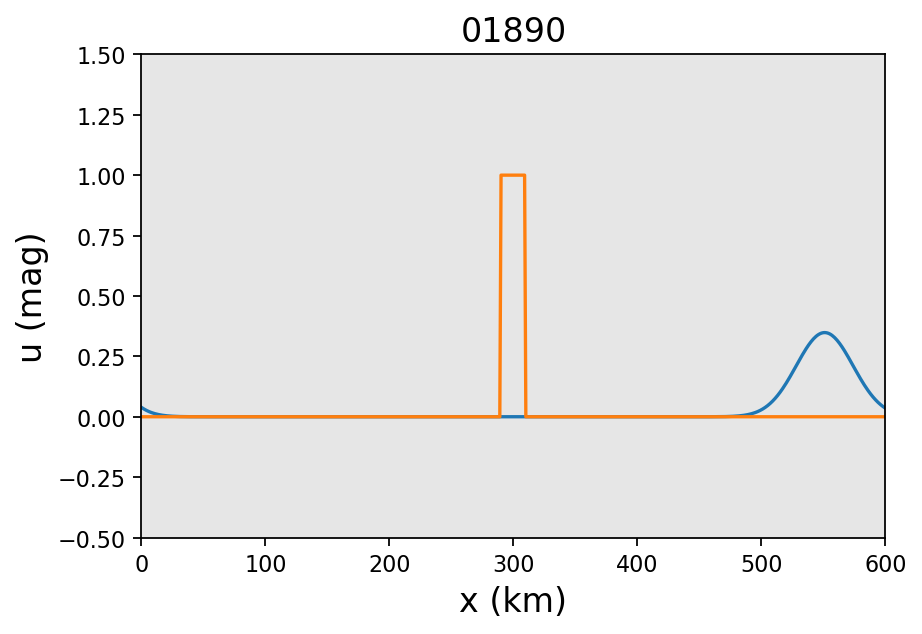

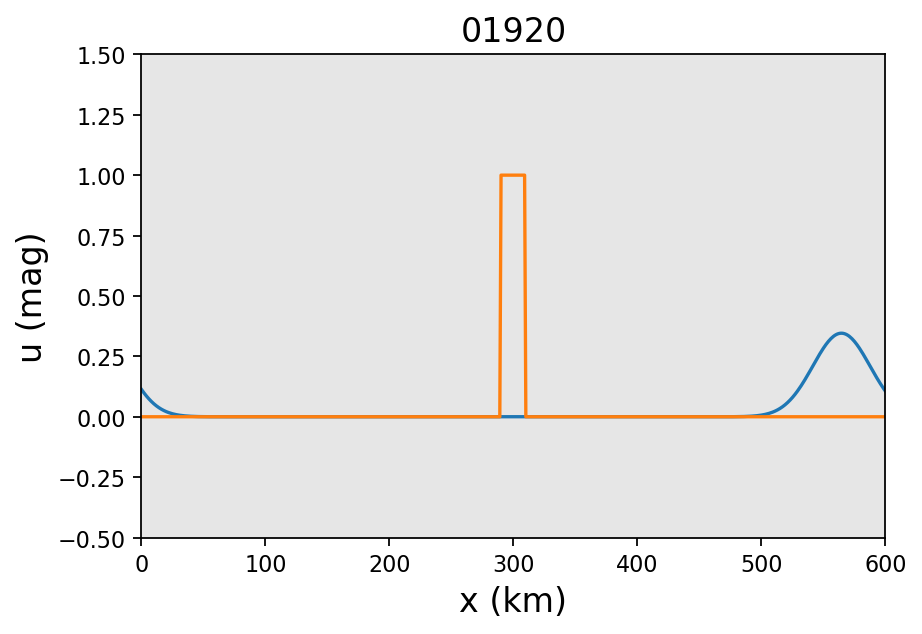

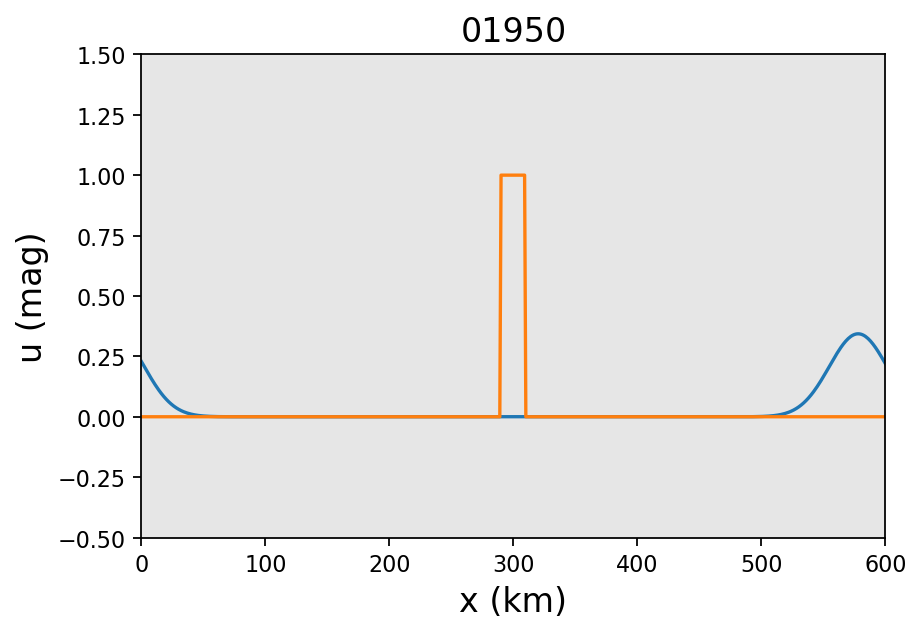

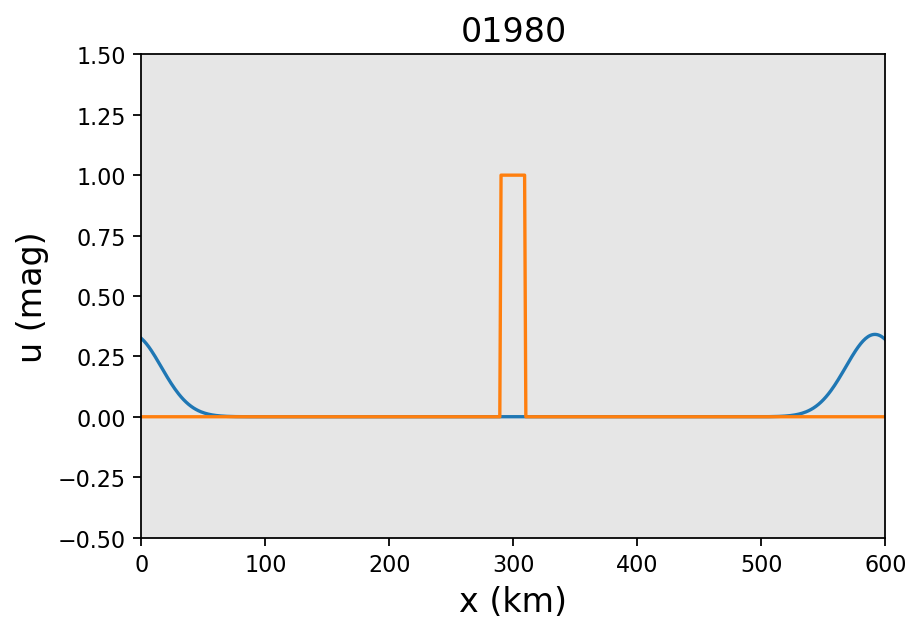

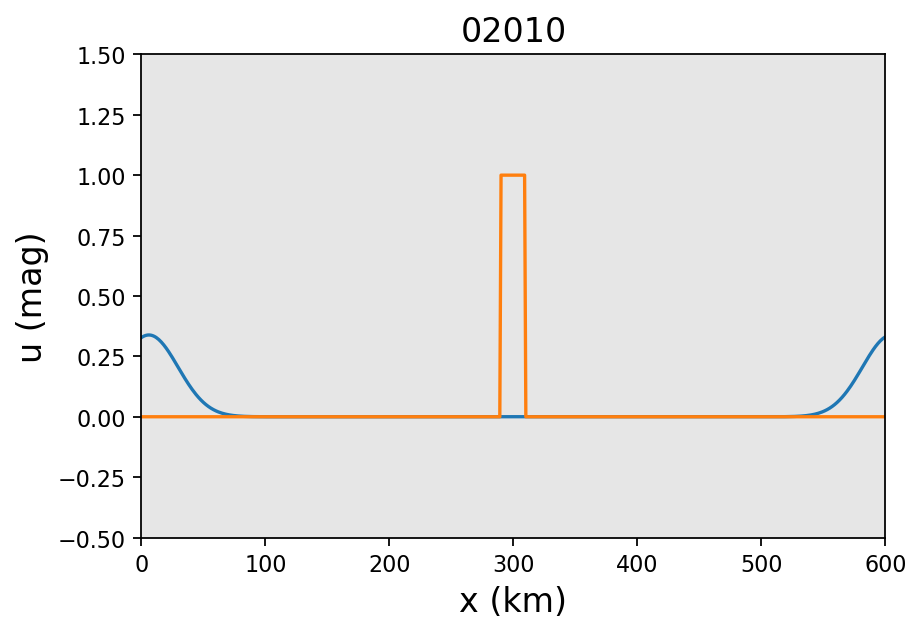

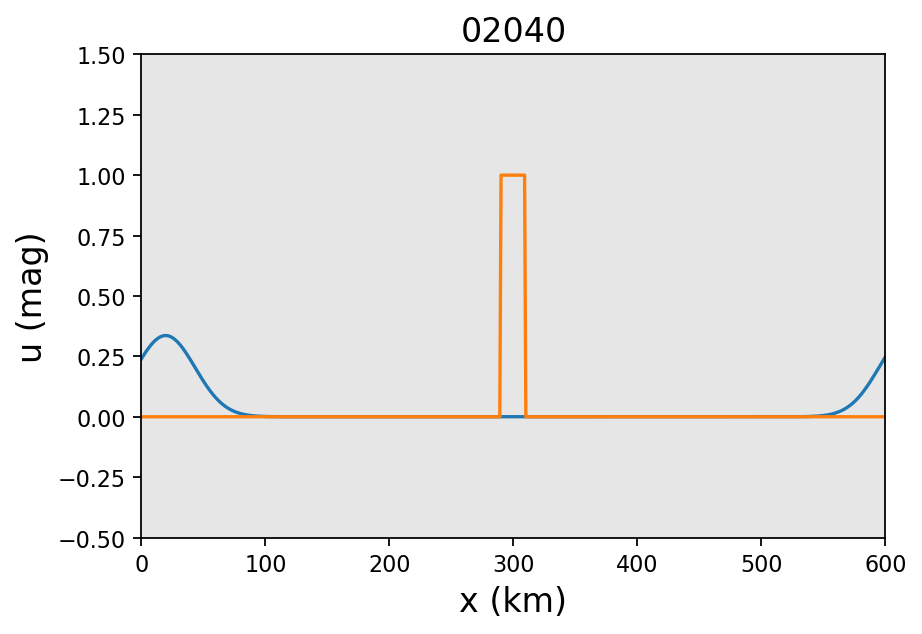

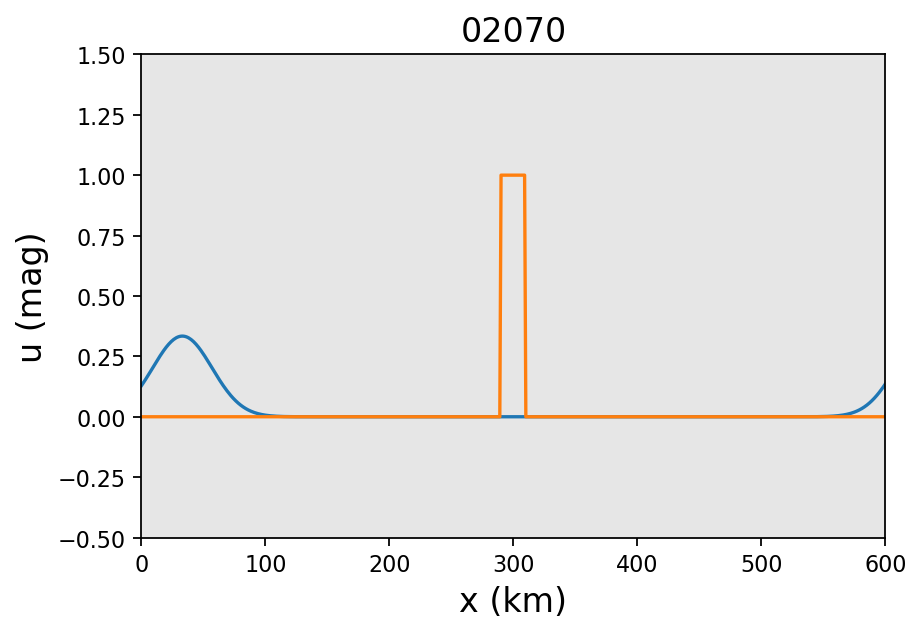

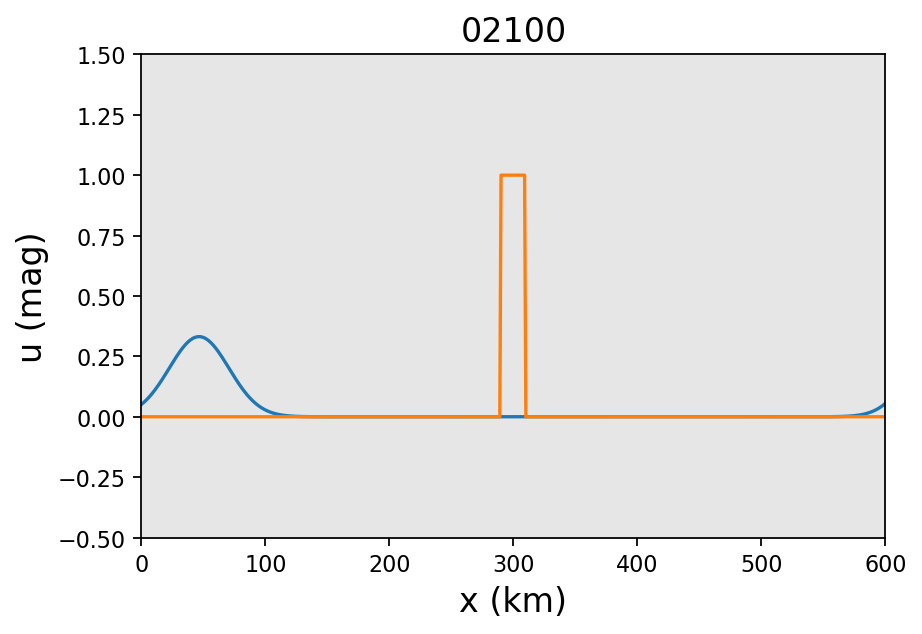

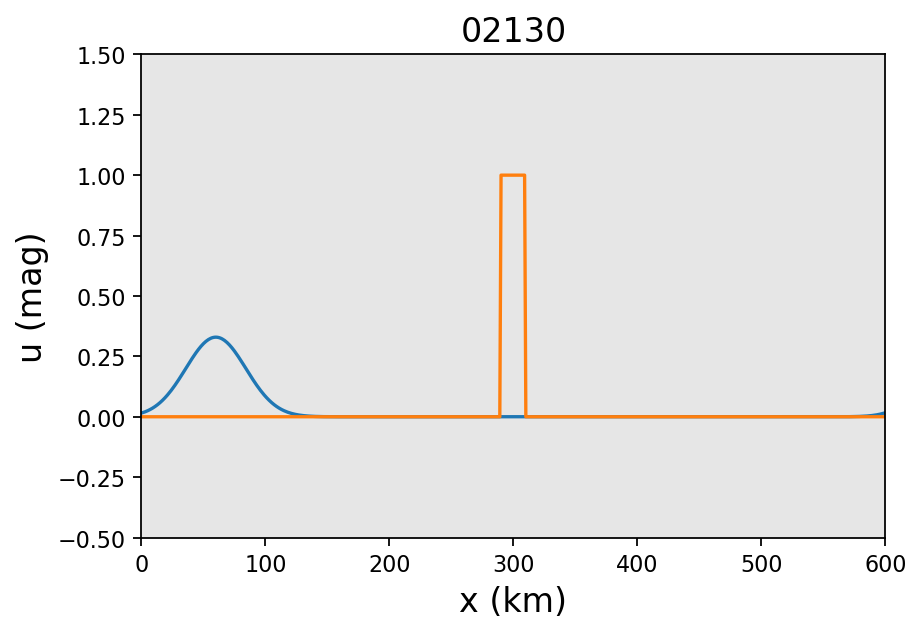

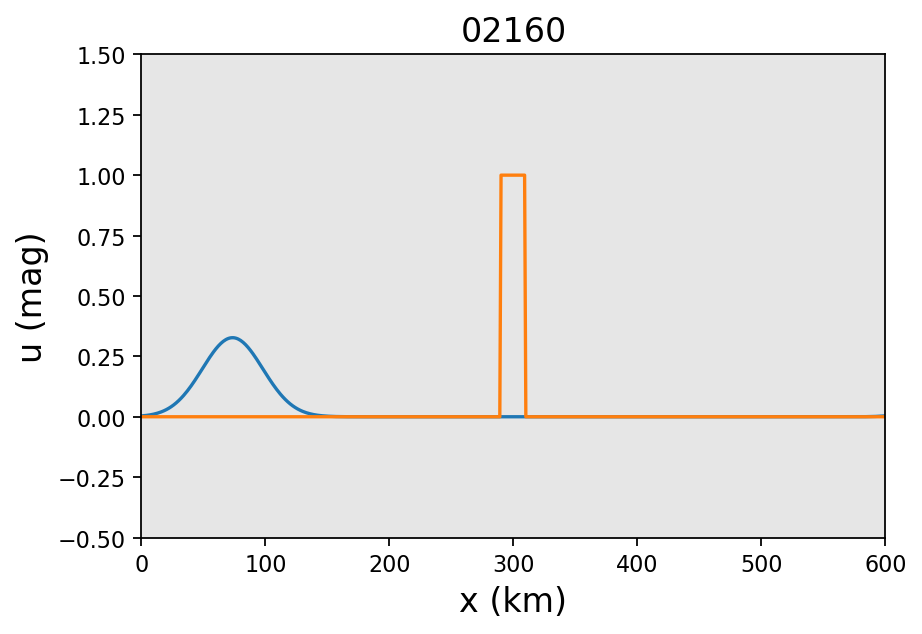

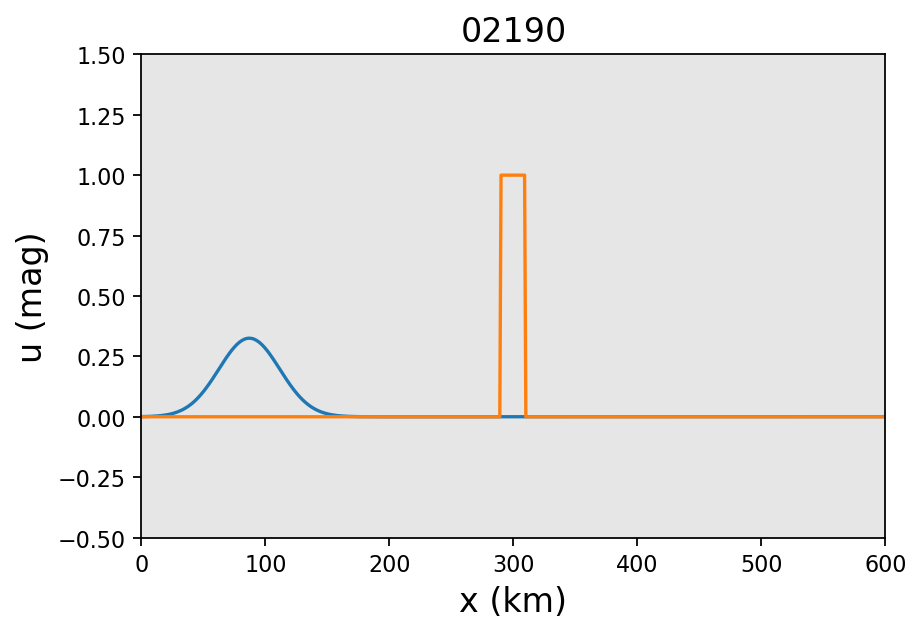

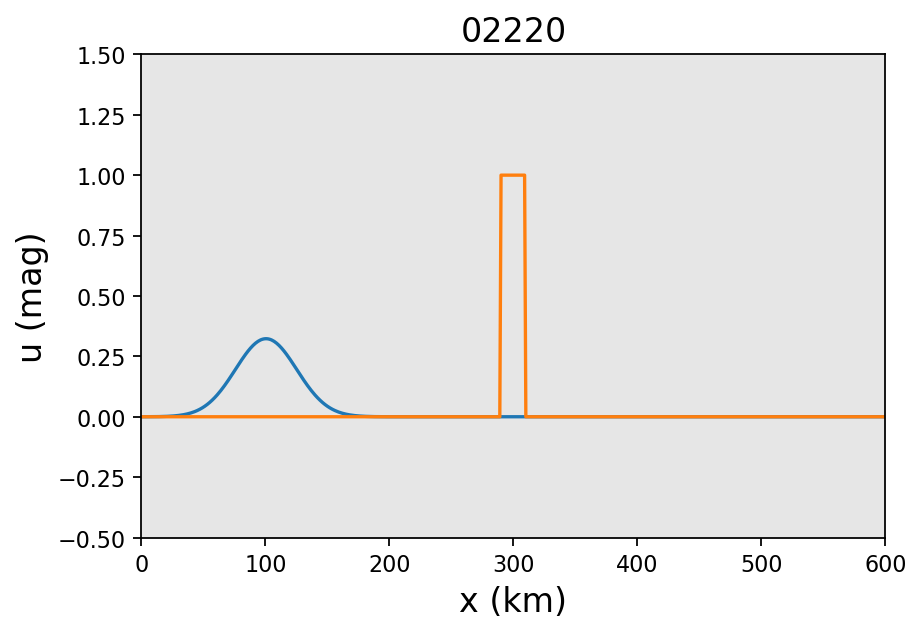

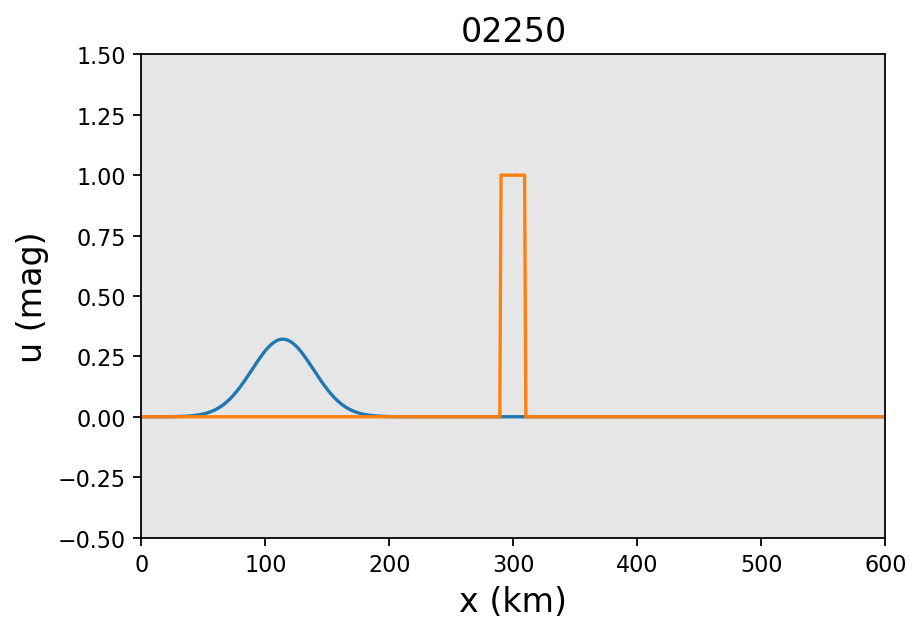

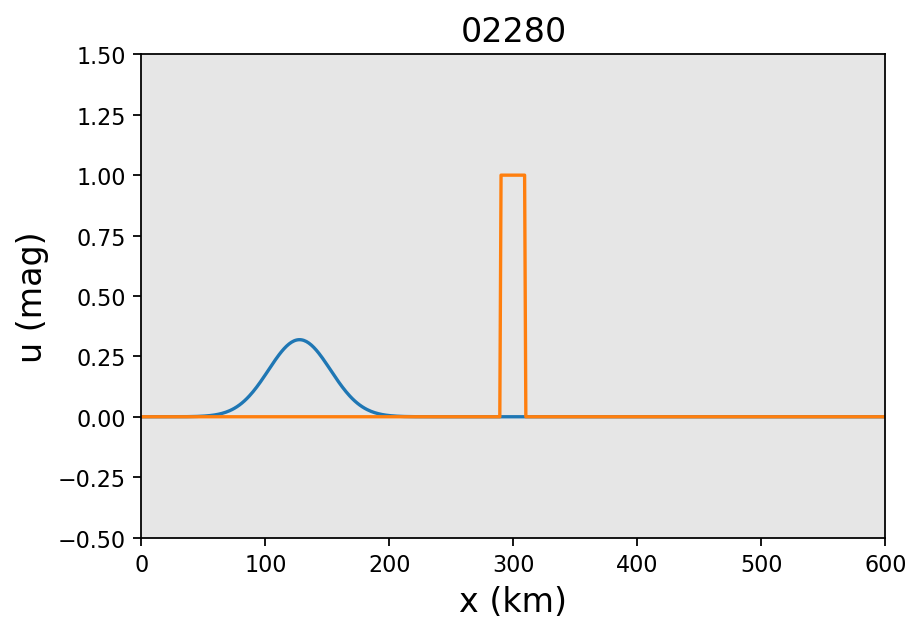

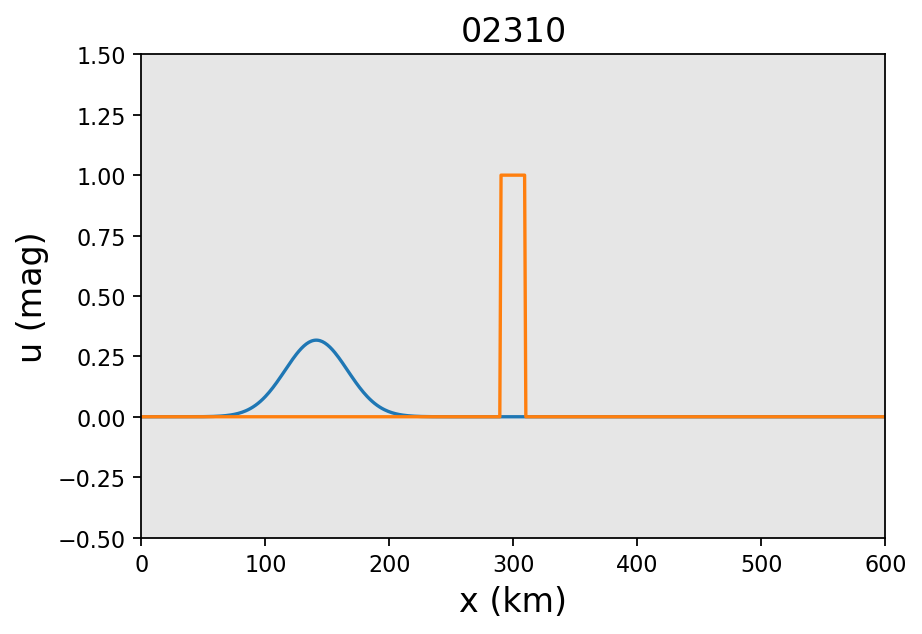

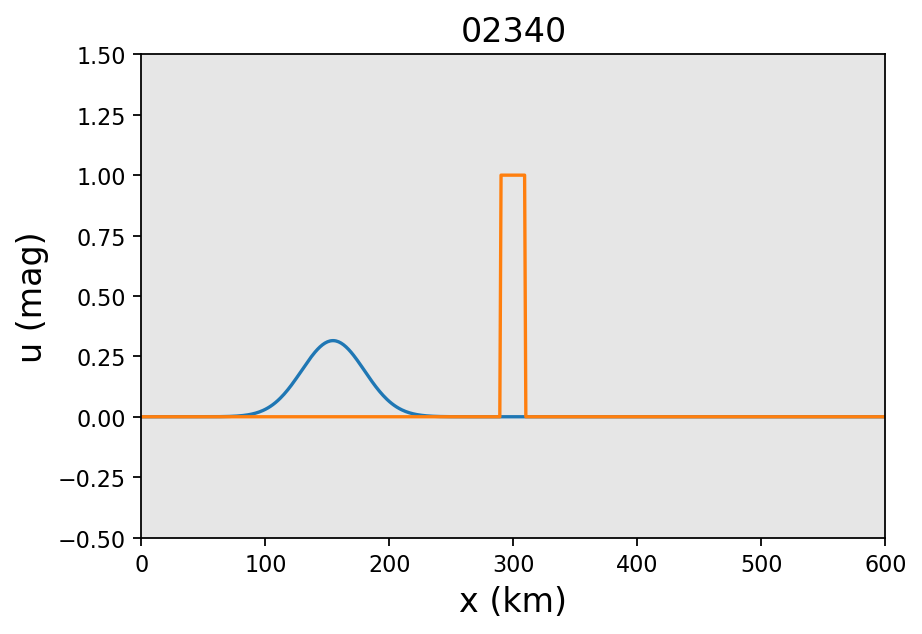

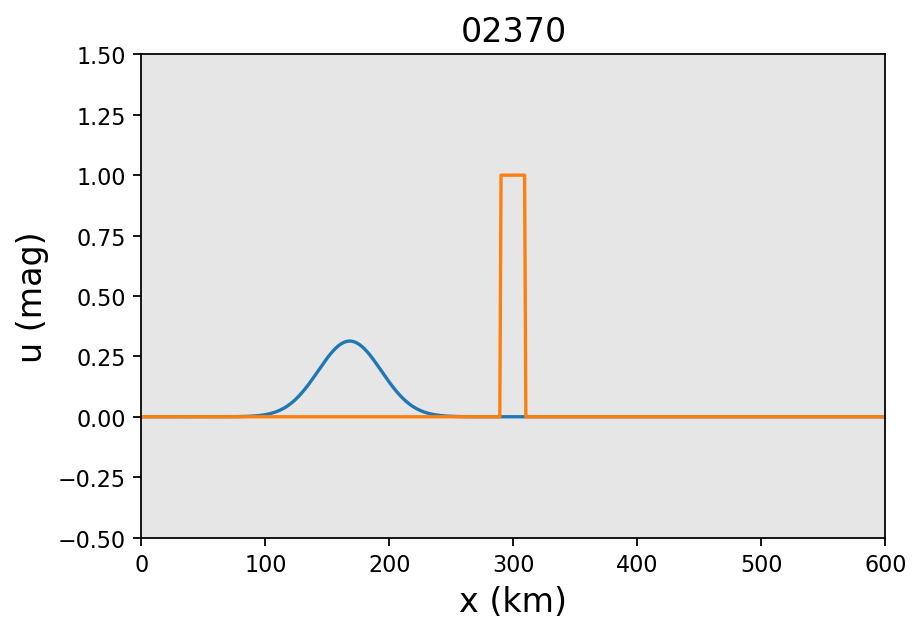

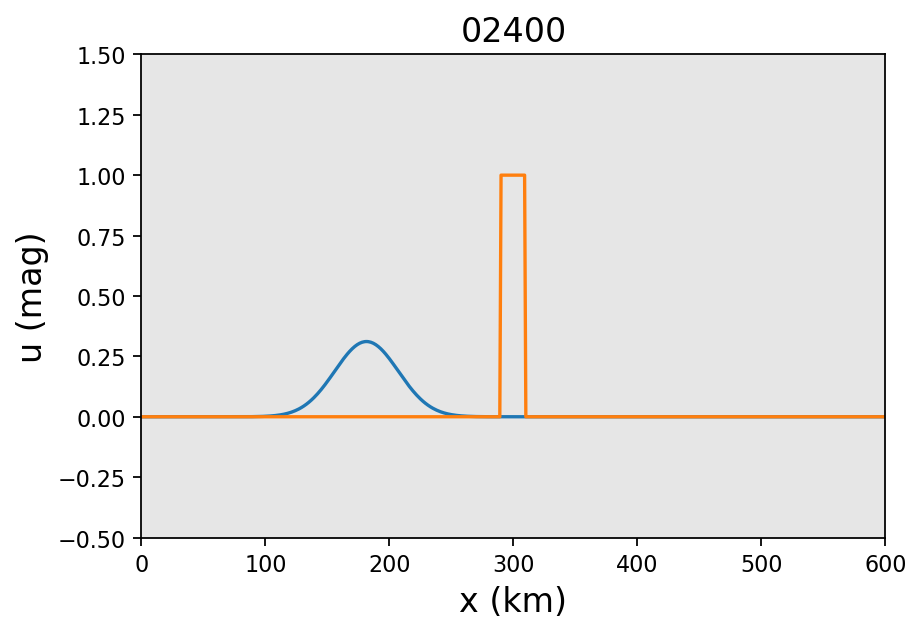

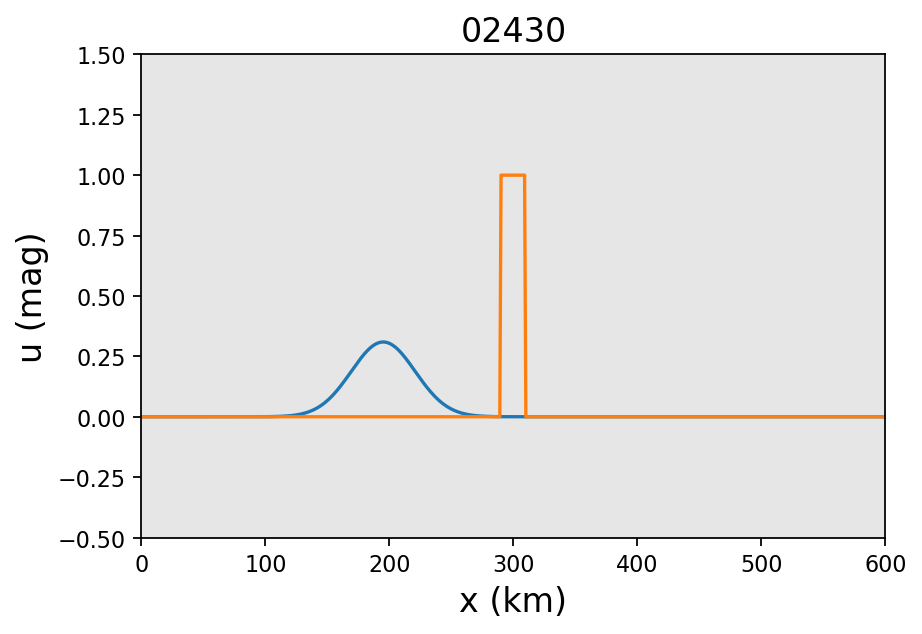

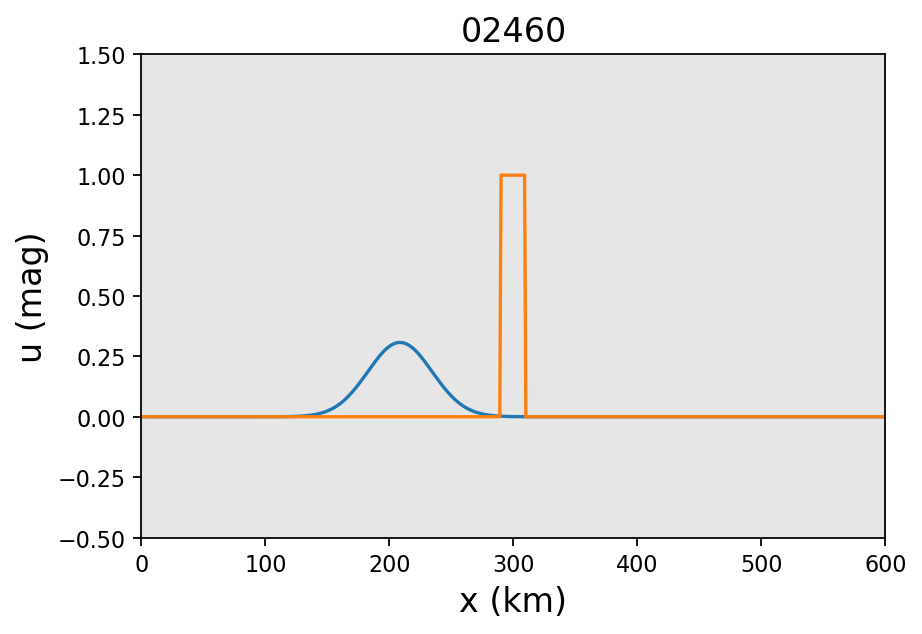

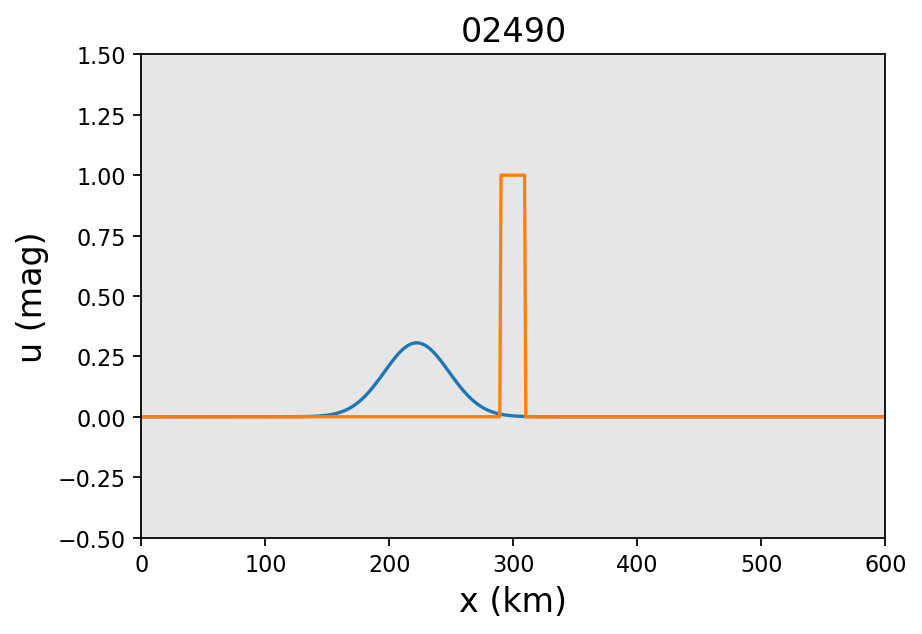

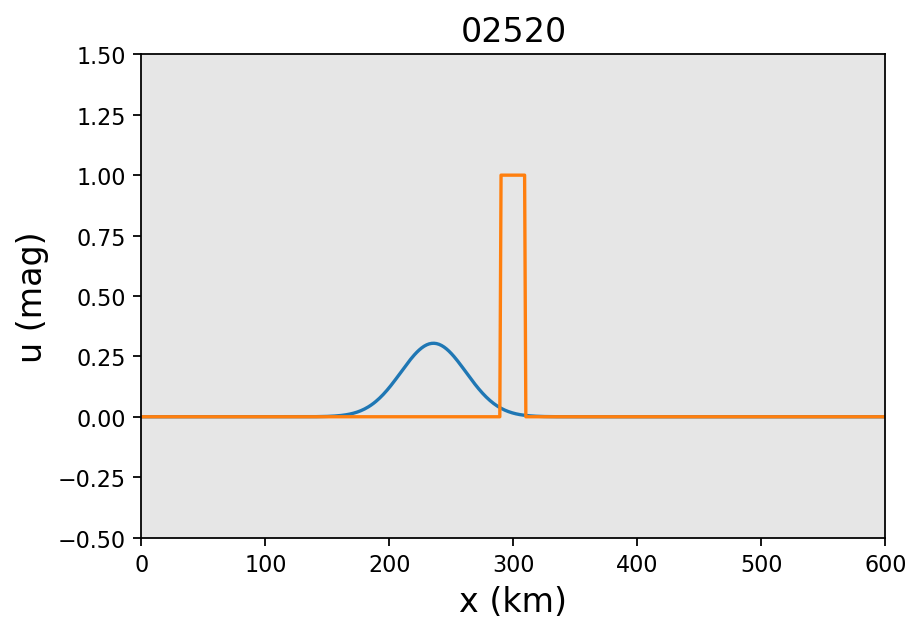

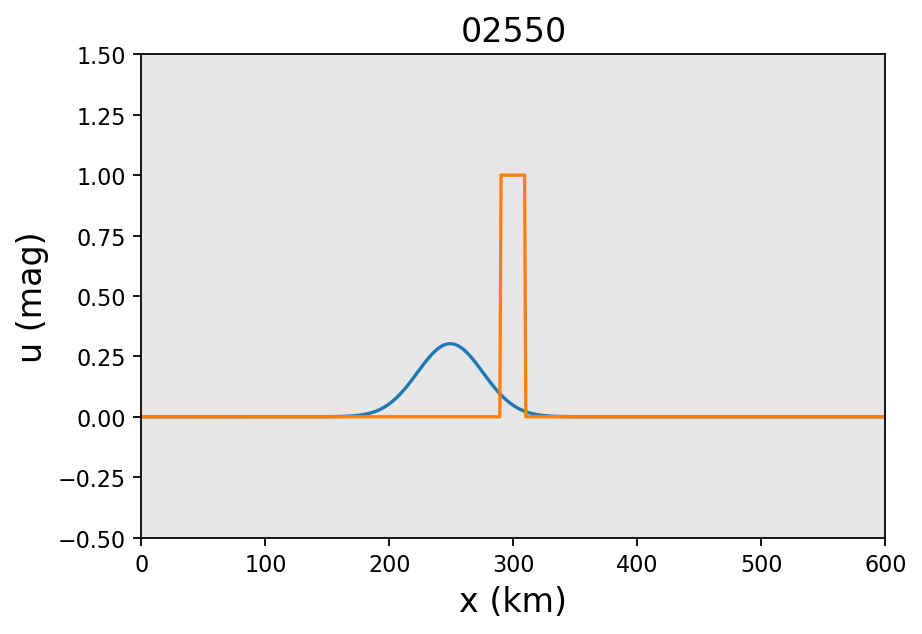

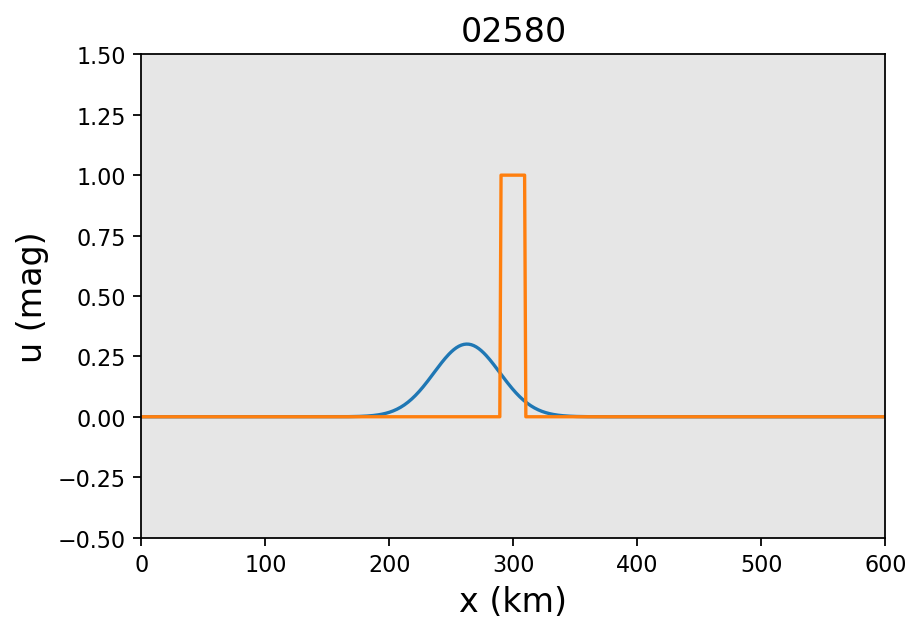

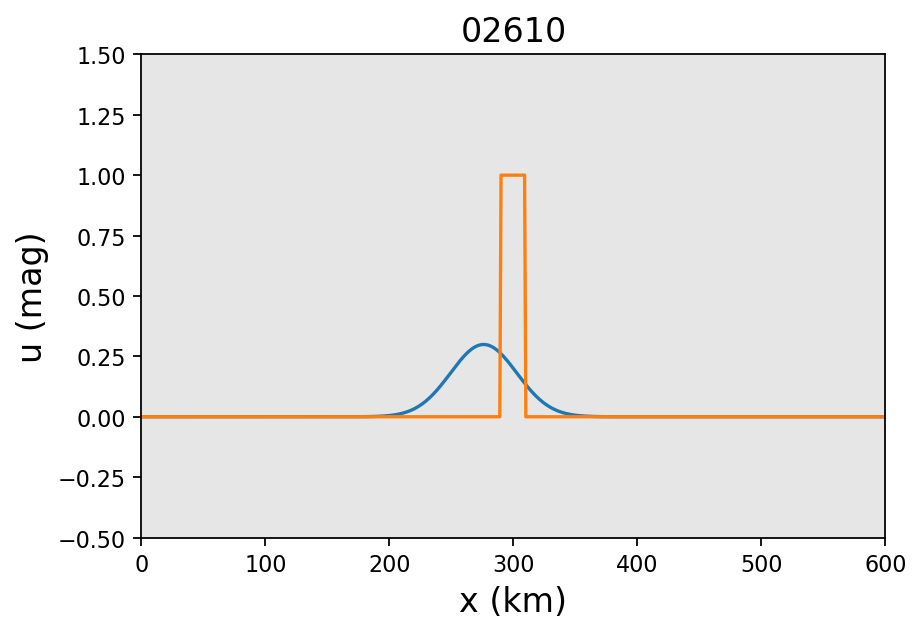

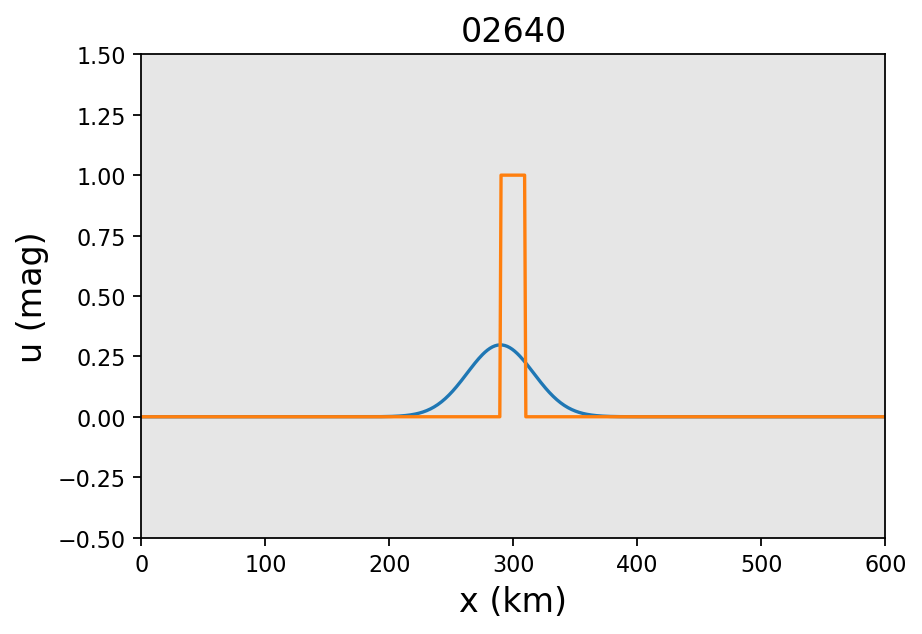

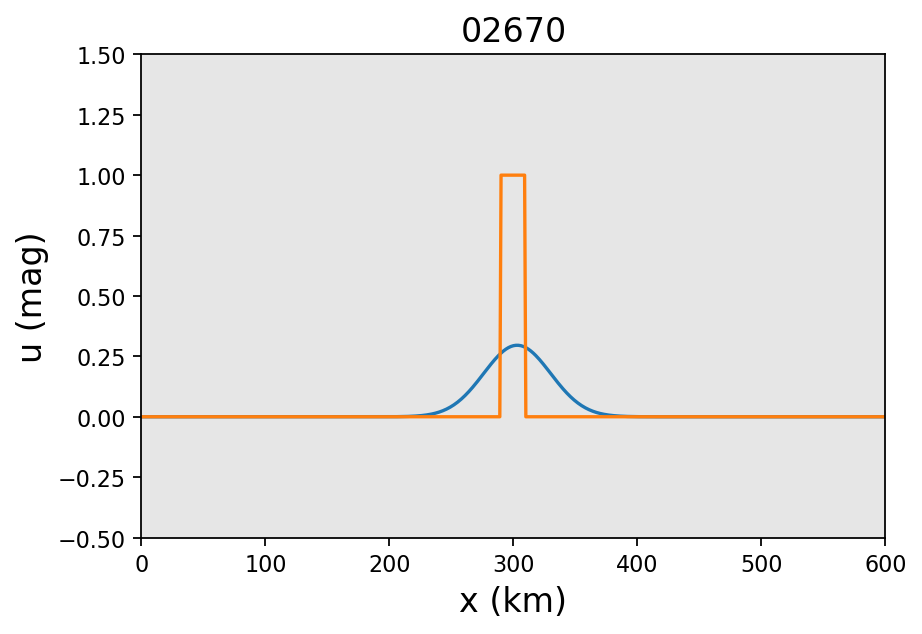

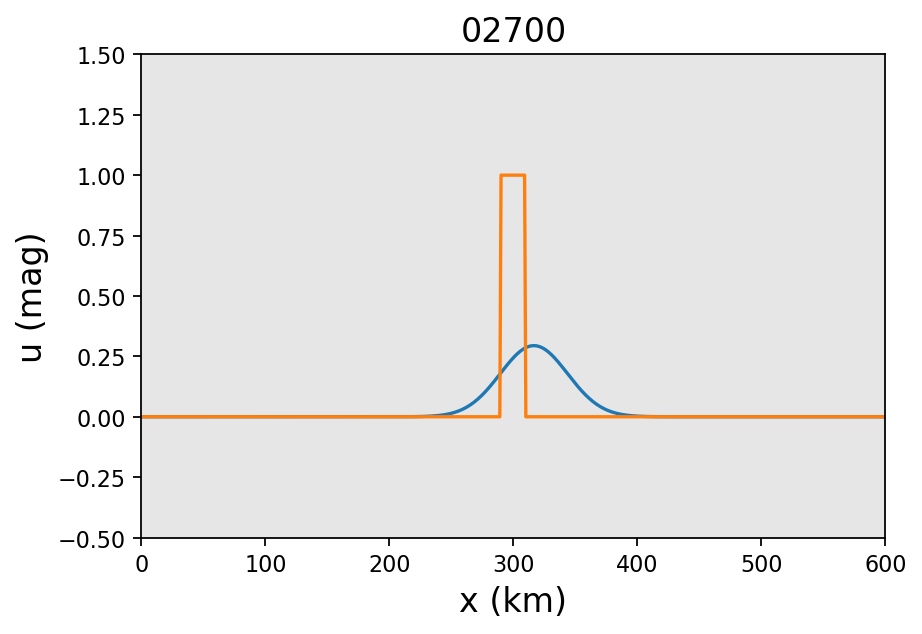

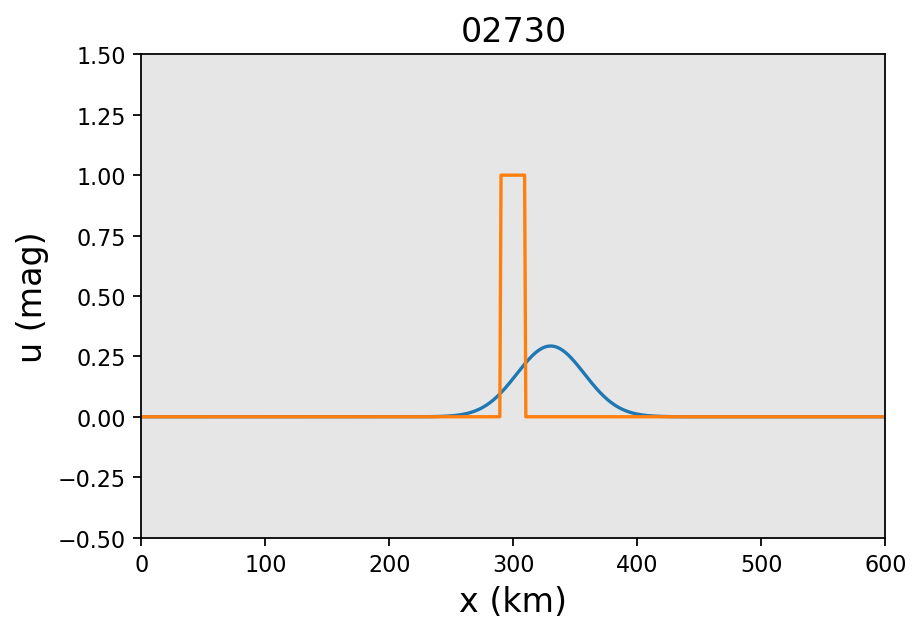

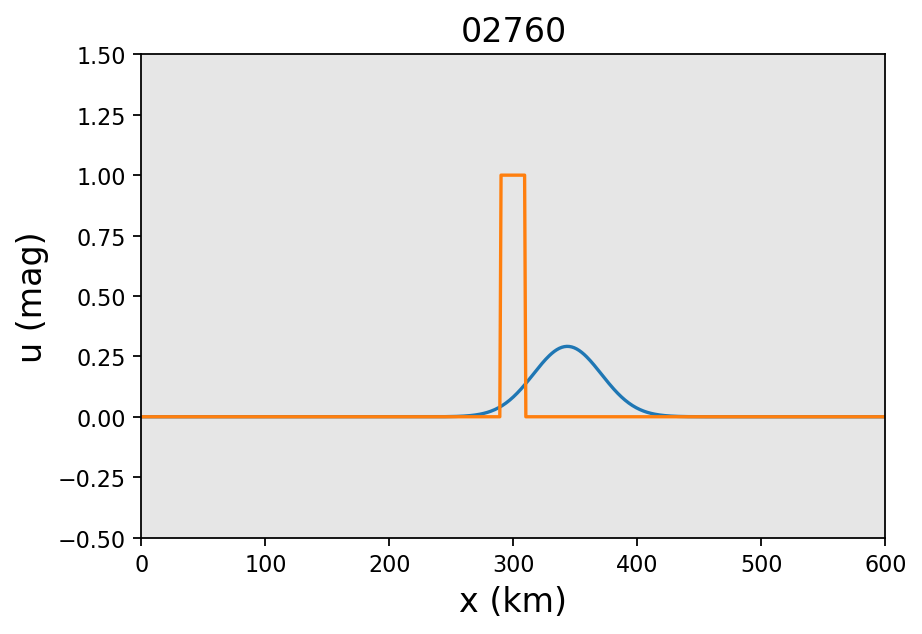

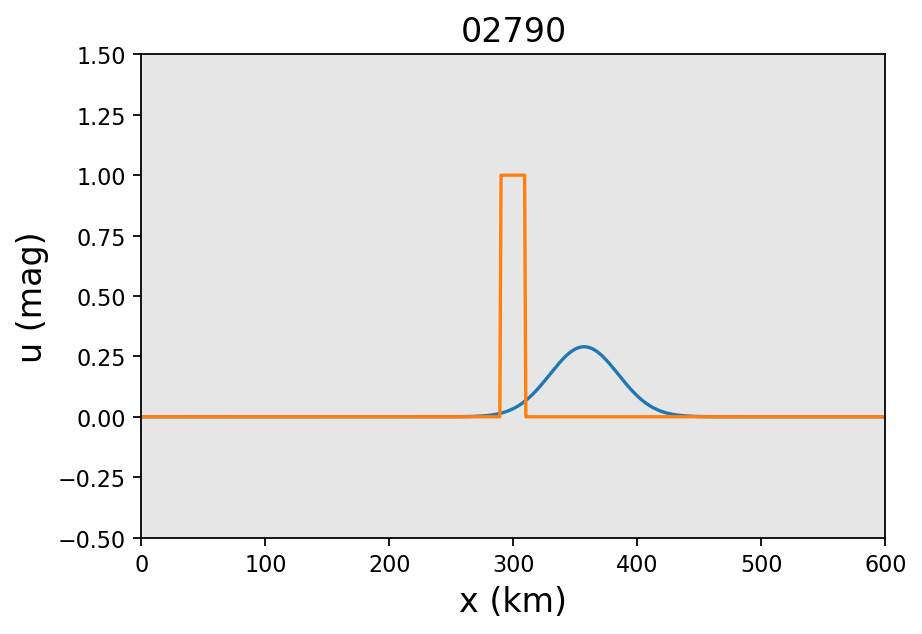

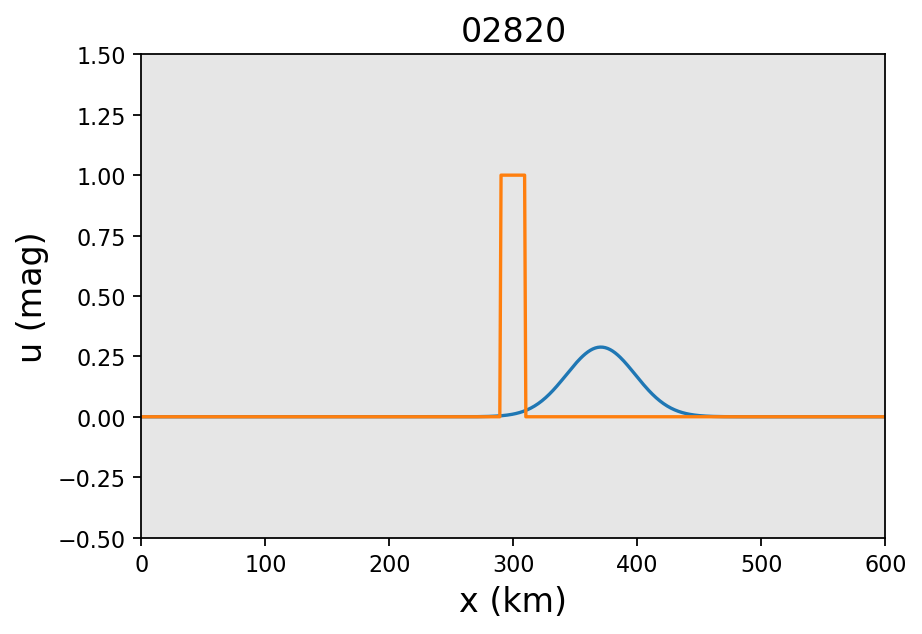

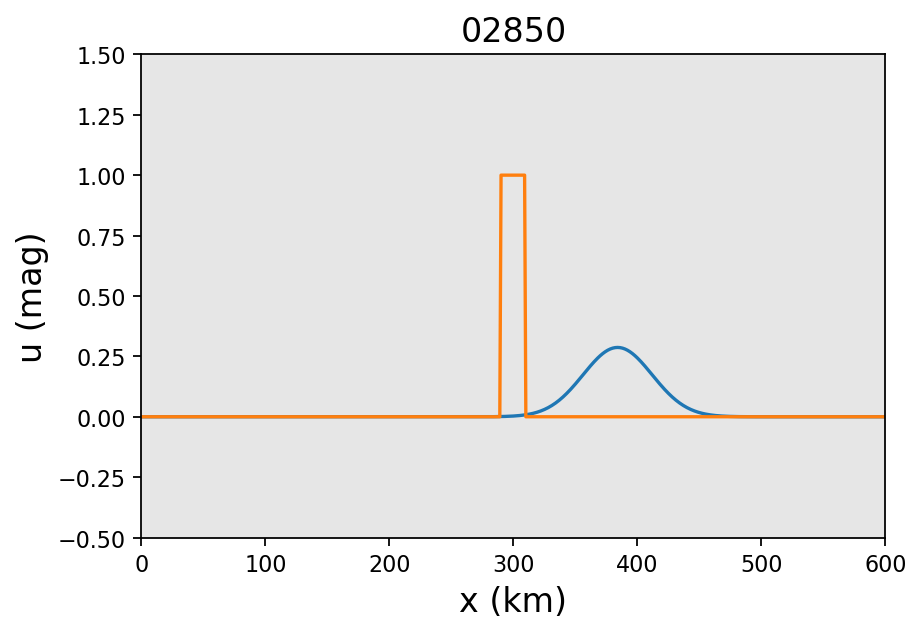

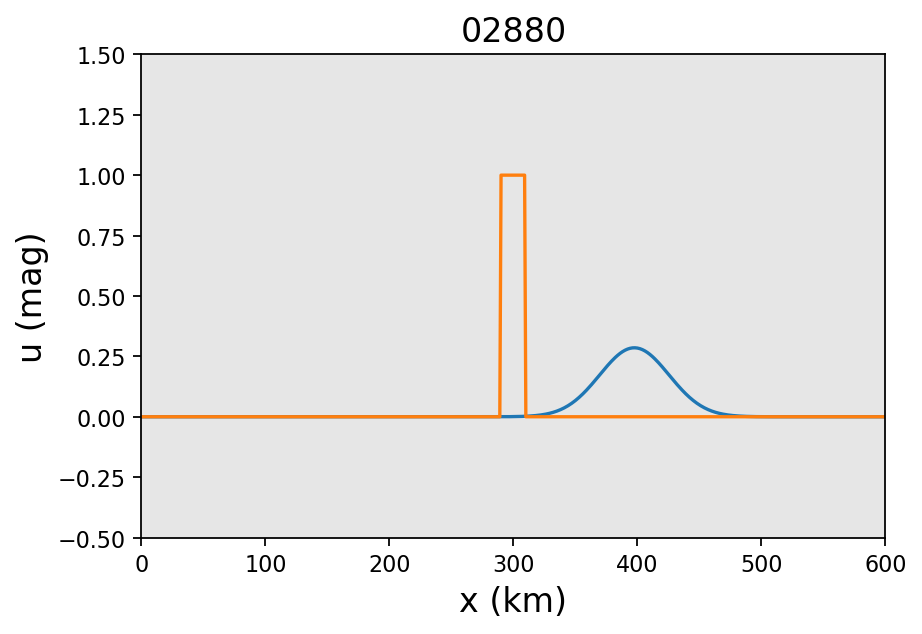

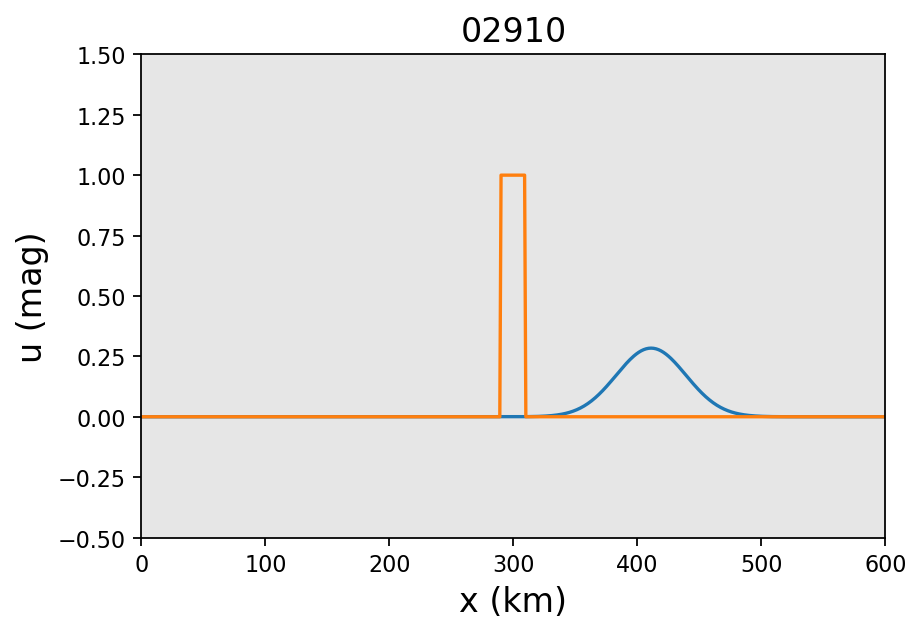

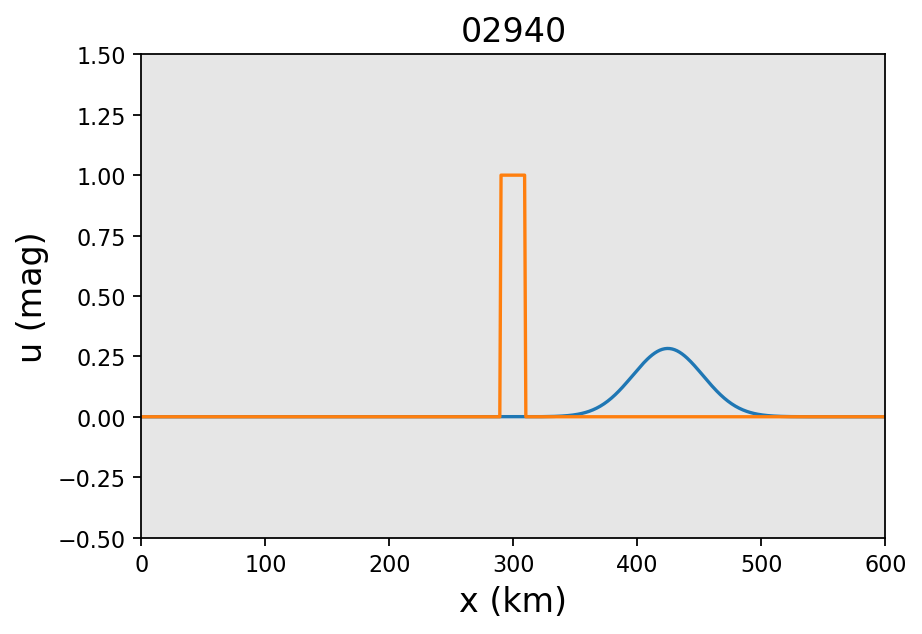

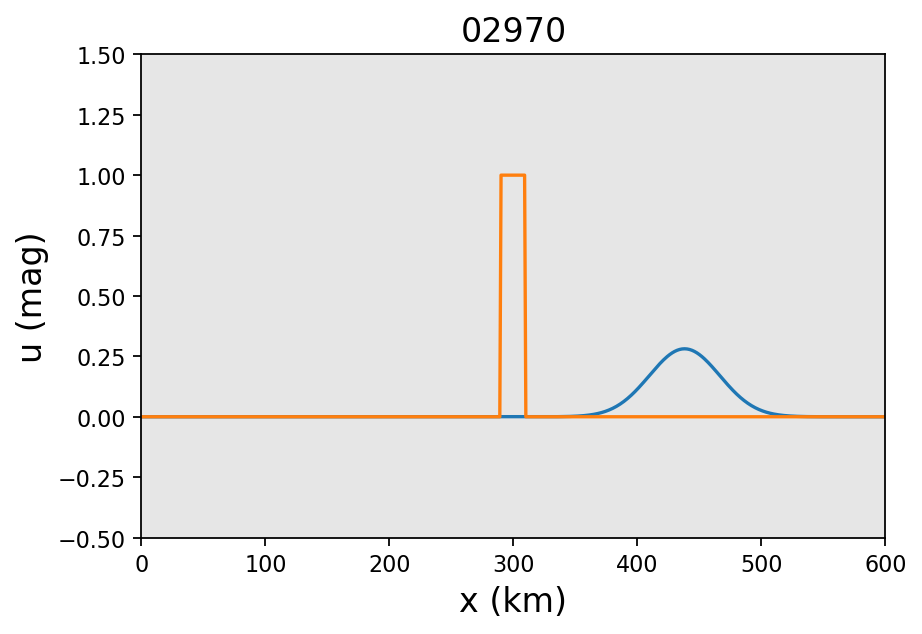

In [157]:
data = np.zeros((n_total, nx))
u_past = np.zeros(nx)
u_now = np.zeros(nx)
u_next = np.zeros(nx)
BC_method = 'periodic'
save = False

for n in range(n_total):
    if n == 0:
        u_next = np.copy(IC(nx))
    
    # else:
    else:
    #1st step
        u_next[1:nx-1] = u_now[1:nx-1] + rho*(u_now[2:nx]+u_now[0:nx-2]-2*u_now[1:nx-1]) - sigma*(u_now[1:nx-1]-u_now[0:nx-2])       #FTBS
        BC(BC_method, u_next, u_now)
        # u_next[0] = u_now[0]
        # u_next[-1] = u_now[-1] 
        
    # else:
    #     u_next[1:nx-1] = u_past[1:nx-1] + 2.*rho*(u_now[2:nx]-2*u_now[1:nx-1]+u_now[0:nx-2]) - sigma*(u_now[2:nx]-u_now[0:nx-2])     #CTCS
    #     BC(BC_method, u_next, u_now)
        # u_next[0] = u_now[0]
        # u_next[-1] = u_now[-1]
    
    u_past = np.copy(u_now)
    u_now = np.copy(u_next)
    data[n] = np.copy(u_now)  
    plot_n_save(n, data, path, save, out_step)

# np.savetxt('result.txt', data, fmt = '%.9g')

In [153]:
image_folder = 'figs'
video_name = f'wave_{BC_method}.mp4v'

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, 20, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()
        